In [1]:
import pandas as pd #Import pandas for operations
import matplotlib.pyplot as plt
import seaborn as sns
from jinja2 import optimizer
from sklearn.model_selection import StratifiedKFold
# from sympy.printing.pytorch import torch

In [2]:
#0. Import data

dataframe = pd.read_csv('data/sdss_100k_galaxy_form_burst.csv', low_memory=False, header=1)

print("Dataset loaded successfully!")
print(f"Dataset shape: {dataframe.shape}")


Dataset loaded successfully!
Dataset shape: (100000, 43)


In [3]:
from scipy.stats import zscore

# 0.1. Data Statistical Analysis

print(f"Dataset shape: {dataframe.shape}")
# print(f"Dataset statistics: {dataframe.describe()}")

numerical_features = dataframe.select_dtypes(include='number').columns
z_scores = dataframe[numerical_features].apply(zscore)  # compute z-score for each numeric column
threshold = 3
outliers_z = (abs(z_scores) > threshold)

print(dataframe[outliers_z.any(axis=1)])  # rows containing at least one outlier
# for col in dataframe.select_dtypes(include='number'):
#     plt.figure()
#     sns.histplot(dataframe[col], kde=True)   # histogram + smooth curve
#     plt.title(col)
#     plt.show()

# Data is somewhat skewed


Dataset shape: (100000, 43)
                     objid            specobjid          ra        dec  \
4      1237648702973149350   332154249716721664  198.706864  -1.046217   
42     1237648721763238209   314301479399745536  170.073523   0.405995   
54     1237651192432165212  8192142948407990272  131.241240  53.208364   
58     1237651251482067624  7181230230211942400  122.631878  45.281591   
72     1237648704061309661  4517153671457560576  231.533375  -0.340179   
...                    ...                  ...         ...        ...   
99928  1237662236392685639  1384880019989358592  184.933948   9.148592   
99936  1237662236929622034  1384887441692846080  185.110612   9.424278   
99957  1237654381978845196   623782117049919488  140.589226  53.606884   
99968  1237664667902214147  2354413718323881984  165.917906  37.929384   
99977  1237664669494804798  1783437871319902208  121.816368  21.689839   

                u           g         r         i         z  modelFlux_u  ...  \
4 

In [4]:
from sklearn.preprocessing import RobustScaler

#1 Data pre-processing

#1.1.0 Smoothen out outliers by means of Robust Scaler
robust_scaler = RobustScaler() # Initialize scaler
robust_scaled_values = robust_scaler.fit_transform(dataframe[numerical_features]) # Scale only numerical data from dataset.
robust_scaled_df = pd.DataFrame(robust_scaled_values, columns=numerical_features, index=dataframe.index) # Convert scaled data to pandas dataframe NB: index so it aligns with OG.
scaled_dataframe = dataframe.copy() # Create a copy of Dataframe to preserve original.
scaled_dataframe[numerical_features] = robust_scaled_df # Copy scaled values over into new copy.

#1.1.1 remove unnecessary columns
modified_dataframe = scaled_dataframe.drop(['objid', 'specobjid', 'class'], axis=1)

# #1.1.2 Encode subclass category accordingly
# modified_dataframe['subclass'] = modified_dataframe['subclass'].map({'STARBURST': 1, 'STARFORMING': 0})

#1.2.1 Split dataset into Test and Training data. (80% Training - 20% Test)
main_training_data = modified_dataframe.sample(frac=0.8)
testing_data = modified_dataframe.drop(main_training_data.index)


#1.2.2 Split Test data into Test and Validation Set. (70% Training - 30% Validation)
training_set = main_training_data.sample(frac=0.7)
validation_set = main_training_data.drop(training_set.index)


In [5]:
#Visualize data.
#1. Training Set Info
print(f"Training Dataset shape: {training_set.shape}")
# print(f"Training Dataset Columns: {list(training_set.columns)}")

#2. Testing Set Info
print(f"Testing Dataset shape: {testing_data.shape}")
# print(f"Testing Dataset Columns: {list(testing_data.columns)}")

#3. Validation Set Info
print(f"Validation Dataset shape: {validation_set.shape}")
# print(f"Validation Dataset Columns: {list(validation_set.columns)}")

assert(len(training_set) + len(testing_data) + len(validation_set) == len(modified_dataframe)) #Confirm that the lengths match.





Training Dataset shape: (56000, 40)
Testing Dataset shape: (20000, 40)
Validation Dataset shape: (24000, 40)


In [6]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_distributions_seaborn(df, figsize=(15, 12)):
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    categorical_cols = df.select_dtypes(exclude=[np.number]).columns

    # Plot numerical distributions
    if len(numerical_cols) > 0:
        n_rows = (len(numerical_cols) + 2) // 3
        fig, axes = plt.subplots(n_rows, 3, figsize=figsize)
        axes = axes.flatten()

        for i, col in enumerate(numerical_cols):
            sns.histplot(data=df, x=col, ax=axes[i], kde=True, bins=30)
            axes[i].axvline(df[col].mean(), color='red', linestyle='--', alpha=0.8)
            axes[i].axvline(df[col].median(), color='green', linestyle='--', alpha=0.8)
            axes[i].set_title(f'Distribution of {col}')

        # Hide empty subplots
        for j in range(i + 1, len(axes)):
            axes[j].set_visible(False)

        plt.tight_layout()
        plt.show()

    # Plot categorical distributions
    if len(categorical_cols) > 0:
        n_rows = (len(categorical_cols) + 2) // 3
        fig, axes = plt.subplots(n_rows, 3, figsize=figsize)
        axes = axes.flatten()

        for i, col in enumerate(categorical_cols):
            value_counts = df[col].value_counts().head(10)
            sns.barplot(x=value_counts.index, y=value_counts.values, ax=axes[i])
            axes[i].set_title(f'Distribution of {col}')
            axes[i].tick_params(axis='x', rotation=45)
            axes[i].set_ylabel('Count')

        # Hide empty subplots
        for j in range(i + 1, len(axes)):
            axes[j].set_visible(False)

        plt.tight_layout()
        plt.show()

# plot_distributions_seaborn(training_set)

In [7]:
from sklearn.preprocessing import StandardScaler
#2. Normalize data.

#2. Apply mean-centering & variance scaling to data

#2.1. Define function
def standardize_with_sklearn(df):
    """
    Use scikit-learn's StandardScaler for robust standardization
    """
    # Separate numerical and categorical columns
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    categorical_cols = df['subclass']

    # Create a copy and only scale numerical columns
    df_normalized = df.copy()

    if len(numerical_cols) > 0:
        scaler = StandardScaler()
        df_normalized[numerical_cols] = scaler.fit_transform(df[numerical_cols])
        df_normalized.drop('subclass', axis=1, inplace=True)

    return df_normalized, categorical_cols

#2.2. Apply standardization
testing_dataset_normalized, testing_dataset_labels = standardize_with_sklearn(testing_data)
training_dataset_normalized, training_dataset_labels = standardize_with_sklearn(training_set)
validation_dataset_normalized, validation_dataset_labels = standardize_with_sklearn(validation_set)

# testing_dataset_normalized.head(5)
# testing_dataset_normalized.shape
# testing_dataset_labels.shape
# validation_dataset_normalized.shape
# validation_dataset_labels.shape
#1.1.2 Encode subclass category accordingly
testing_dataset_labels = testing_dataset_labels.map({'STARBURST': 1, 'STARFORMING': 0})
training_dataset_labels = training_dataset_labels.map({'STARBURST': 1, 'STARFORMING': 0})
validation_dataset_labels = validation_dataset_labels.map({'STARBURST': 1, 'STARFORMING': 0})


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

#3. Begin Training Model.
# print(torch.cuda.is_available())

#3.1. Setup Model with Params. TODO: Specify weights!!
class galaxy_classification_nn(nn.Module):
    def __init__(self):

        super().__init__()
        self.input_layer = nn.Linear(in_features=39, out_features=133)
        self.hidden_layer = nn.Linear(in_features=133, out_features=133)
        self.output_layer = nn.Linear(in_features=133, out_features=2)

        #Specify activation functions.
        self.activation_function1 = nn.Tanh() # Input -> Hidden 1
        self.activation_function2 = nn.ReLU() # Hidden 1 -> Hidden 2
        self.activation_function3 = nn.Softmax(dim=1) # Hidden 2 -> Output TODO: Validate dim param

    def forward(self, x):
        x = self.input_layer(x)
        x = self.activation_function1(x)

        x = self.hidden_layer(x)
        x = self.activation_function2(x)

        x = self.output_layer(x)
        x = self.activation_function3(x)

        return x

        # x = F.relu(self.fc1(x)) # TODO: Check why not linear.
        # x = F.relu(self.fc2(x))
        # x = F.softmax(self.fc3(x), dim=1)
        # x = self.fc3(x)                  # raw scores (logits)
        return x

    def get_weights(self, model_type):
        if model_type == 'traditional':
            init.xavier_normal_(self.input_layer.weight, )
            init.kaiming_normal(self.hidden_layer.weight)
            init.xavier_normal_(self.output_layer.weight)
            return
        elif model_type == 'sign_based':
            init.xavier_normal_(self.input_layer.weight)

In [9]:
from torch.utils.data import TensorDataset, DataLoader


training_features = training_dataset_normalized.values

training_labels = training_dataset_labels.values

testing_features = testing_dataset_normalized.values

testing_labels = testing_dataset_labels.values


# TODO: Add Validation tensors
training_tensor_features = torch.tensor(training_features, dtype=torch.float32)

training_tensor_labels = torch.tensor(training_labels, dtype=torch.long)

testing_tensor_features = torch.tensor(testing_features, dtype=torch.float32)

testing_tensor_labels = torch.tensor(testing_labels, dtype=torch.long)

# Create Datasets
training_dataset = TensorDataset(training_tensor_features, training_tensor_labels)
testing_dataset = TensorDataset(testing_tensor_features, testing_tensor_labels)

training_dataset_loader = DataLoader(training_dataset, batch_size=64, shuffle=True)

testing_dataset_loader = DataLoader(testing_dataset, batch_size=64, shuffle=True)

print(training_tensor_features.dtype)
# print(training_dataset_labels)

# training_dataset_normalized.head(5)
#
# train_tensor_features = torch.tensor(training_dataset_normalized.values, dtype=torch.float32)
#
# train_tensor_labels = torch.tensor(training_dataset_labels.values, dtype=torch.float32)
#
# training_dataset = TensorDataset(train_tensor_features, train_tensor_labels)
#

torch.float32


In [10]:
import torch.optim as optim

#3.2. Init. model
device = torch.device("cuda:0" if torch.cuda.is_available () else "cpu")

galaxy_classification_model = galaxy_classification_nn().to(device)

#3.2. Setup Optimizer
loss_function = nn.CrossEntropyLoss()
error_optimizer = optim.Rprop(
    galaxy_classification_model.parameters(),
    lr=0.01,        # initial step size per weight
    etas=(0.5, 1.2),# (eta_minus, eta_plus)
    step_sizes=(1e-6, 50.0)  # (min_step, max_step)
)


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score,precision_score, recall_score,confusion_matrix, ConfusionMatrixDisplay


k_fold = StratifiedKFold(n_splits=10, shuffle=True)

accuracy_score_list = []
f1_score_list = []
epoch_count = 10

# 1. Get Dataset Labels & Features
dataset_features = modified_dataframe.select_dtypes(include=[np.number])
dataset_labels = modified_dataframe['subclass'].map({'STARBURST': 1, 'STARFORMING': 0})

# print(features.shape)
# print(labels.shape)


for fold, (train_index, test_index) in enumerate(k_fold.split(dataset_features, dataset_labels), 1):
    print(f"\nCurrent Fold {fold}:")

    # 2. Split current folds into test and training set
    features_train, features_test = dataset_features.copy().iloc[train_index], dataset_features.copy().iloc[test_index]
    labels_train, labels_test =dataset_labels.copy().iloc[train_index], dataset_labels.copy().iloc[test_index]

    features_train_numpy = features_train.to_numpy()
    features_test_numpy = features_test.to_numpy()
    # 3. Normalize dataset
    standard_scaler = StandardScaler()
    features_train_scaled = standard_scaler.fit_transform(features_train_numpy)
    features_test_scaled = standard_scaler.transform(features_test_numpy)

    # 4. Convert to Tensors
    features_train_tensor = torch.tensor(features_train_scaled, dtype=torch.float32)
    features_test_tensor = torch.tensor(features_test_scaled, dtype=torch.float32)
    labels_train_tensor = torch.tensor(labels_train.to_numpy(), dtype=torch.long)
    labels_test_tensor = torch.tensor(labels_test.to_numpy(), dtype=torch.long)

    # 5. Create Dataloaders
    training_dataset_converted = TensorDataset(features_train_tensor, labels_train_tensor)
    testing_dataset_converted = TensorDataset(features_test_tensor, labels_test_tensor)

    training_dataset_loader = DataLoader(training_dataset_converted, batch_size=64, shuffle=True)
    testing_dataset_loader = DataLoader(testing_dataset_converted, batch_size=64, shuffle=True)

    # 6. Compute class weights to address class imbalance
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels_train), y=labels_train.to_numpy())
    class_weights = torch.tensor(class_weights, dtype=torch.float32)

    # 7. Redefine model in training loop.
    galaxy_classification_model = galaxy_classification_nn().to(device)
    loss_function = nn.CrossEntropyLoss()
    error_optimizer = optim.Rprop(
        galaxy_classification_model.parameters(),
        lr=0.01,        # initial step size per weight
        etas=(0.5, 1.2),# (eta_minus, eta_plus)
        step_sizes=(1e-6, 50.0)  # (min_step, max_step)
    )

    # 8. Begin training loop for fold
    galaxy_classification_model.train()
    for epoch in range(epoch_count):
        for features, labels in training_dataset_loader:
            error_optimizer.zero_grad()
            outputs = galaxy_classification_model(features)
            loss = loss_function(outputs, labels)
            loss.backward()
            error_optimizer.step()

    # 9. Evaluation loop
    galaxy_classification_model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for features, labels in testing_dataset_loader:
            outputs = galaxy_classification_model(features)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())


    # Compute metrics

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")

    accuracy_score_list.append(acc)
    f1_score_list.append(f1)

    # Per-class precision and recall
    precision_per_class = precision_score(all_labels, all_preds, average=None)
    recall_per_class    = recall_score(all_labels, all_preds, average=None)

    print(f"Fold {fold} Accuracy: {acc:.3f}, F1: {f1:.3f}")
    for cls_idx, (prec, rec) in enumerate(zip(precision_per_class, recall_per_class)):
        print(f"  Class {cls_idx} -> Precision: {prec:.3f}, Recall: {rec:.3f}")

    print(f"Fold {fold} Accuracy: {acc:.3f}, F1: {f1:.3f}")

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', colorbar=False)
    plt.title("Confusion Matrix")
    plt.show()
# Average results across folds
print("\n=== Final Results ===")
print("Average Accuracy:", np.mean(accuracy_score_list))
print("Average F1-score:", np.mean(f1_score_list))


Current Fold 1:


Epoch: 1
Loss: 0.5192418098449707
Classification accuracy: 79.69%


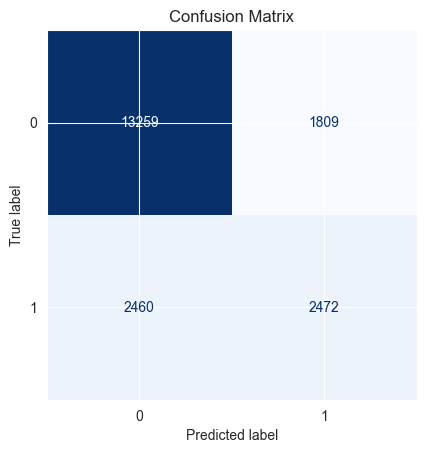

Loss: 0.5411233901977539
Classification accuracy: 75.00%


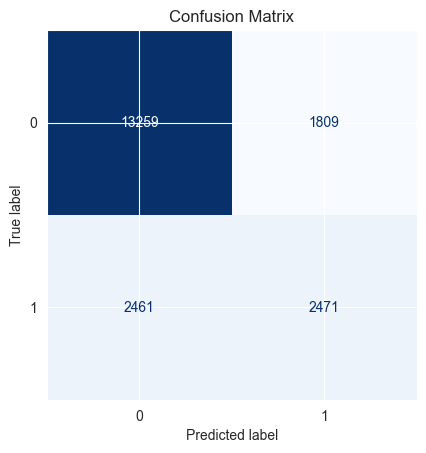

Loss: 0.4541897773742676
Classification accuracy: 85.94%


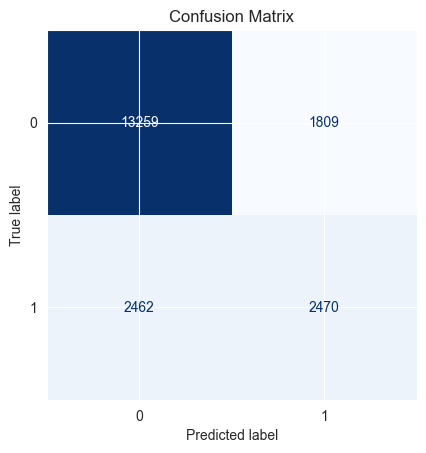

Loss: 0.4231512248516083
Classification accuracy: 89.06%


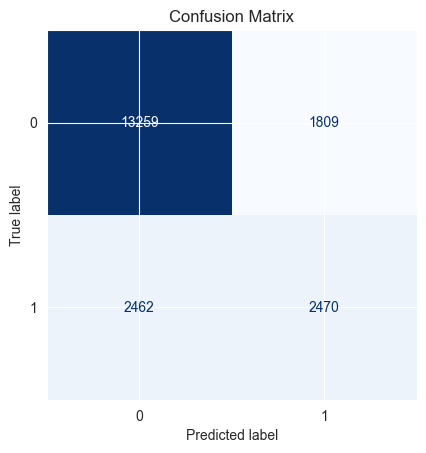

Loss: 0.502691388130188
Classification accuracy: 79.69%


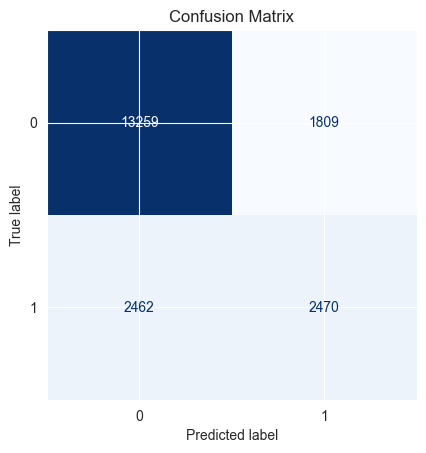

Loss: 0.4595789909362793
Classification accuracy: 85.94%


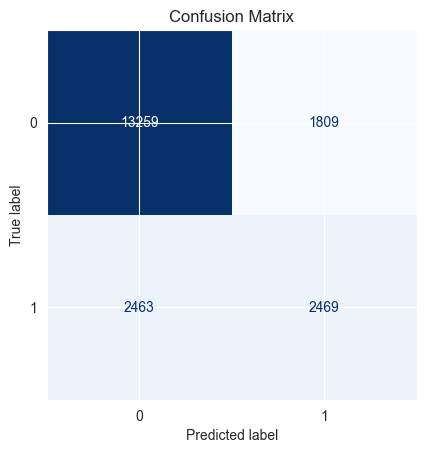

Loss: 0.42639777064323425
Classification accuracy: 89.06%


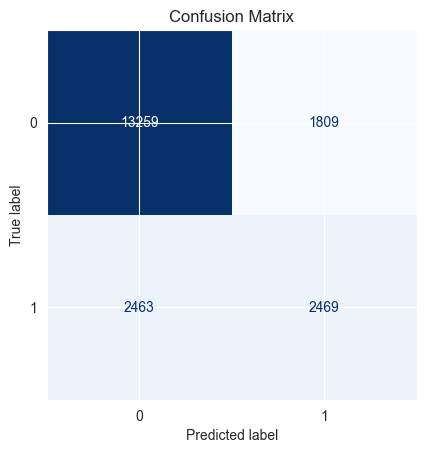

Loss: 0.42732977867126465
Classification accuracy: 87.50%


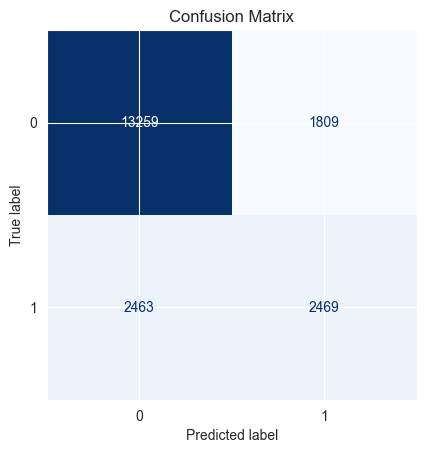

Loss: 0.4327467978000641
Classification accuracy: 85.94%


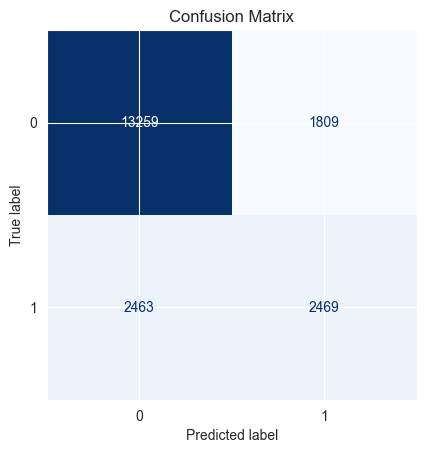

Loss: 0.47939208149909973
Classification accuracy: 85.94%


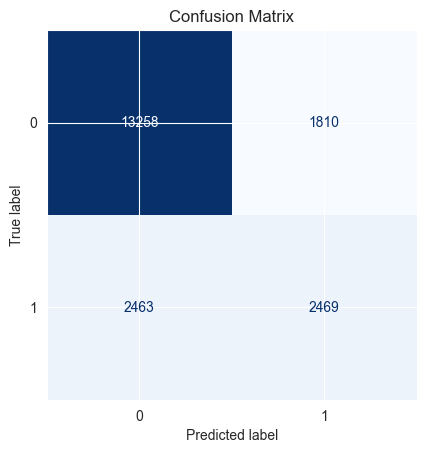

Loss: 0.4562278985977173
Classification accuracy: 85.94%


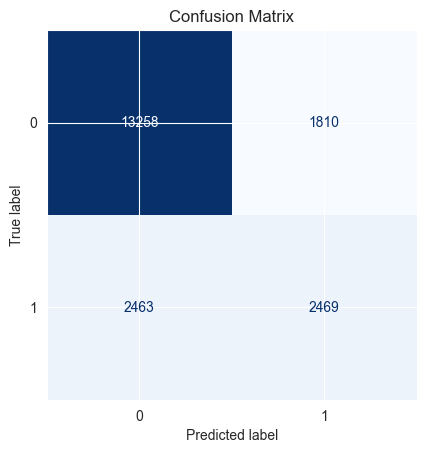

Loss: 0.5545158982276917
Classification accuracy: 75.00%


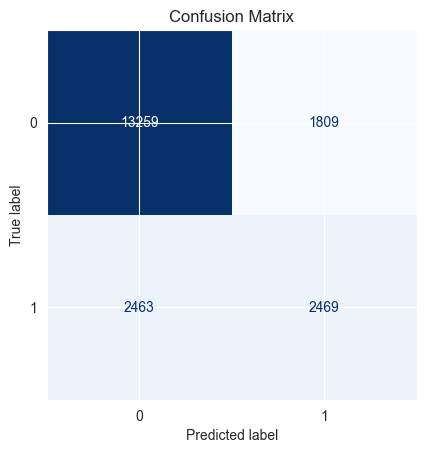

Loss: 0.5134894847869873
Classification accuracy: 78.12%


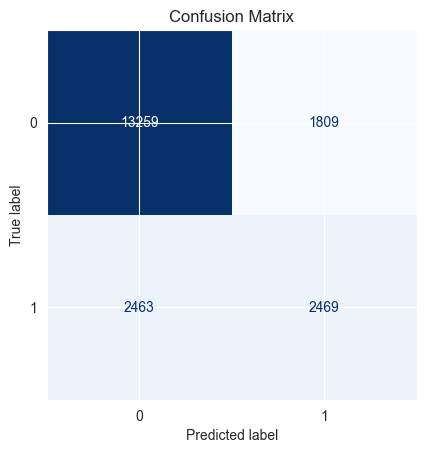

Loss: 0.6143641471862793
Classification accuracy: 70.31%


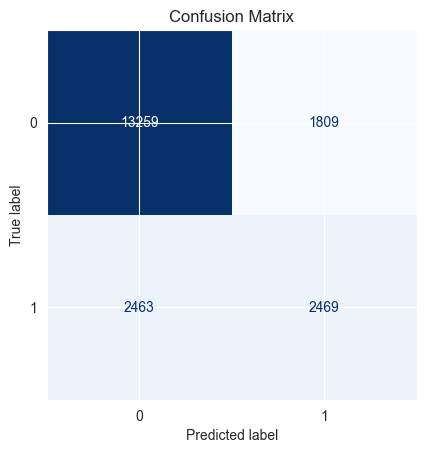

Loss: 0.48184263706207275
Classification accuracy: 81.25%


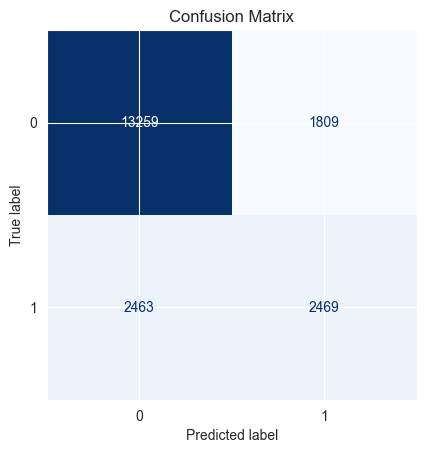

Loss: 0.46928590536117554
Classification accuracy: 85.94%


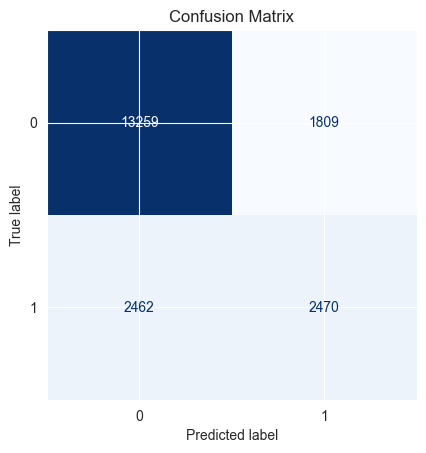

Loss: 0.5401548147201538
Classification accuracy: 75.00%


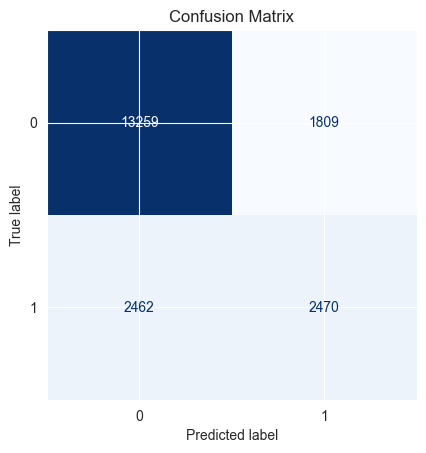

Loss: 0.4705786108970642
Classification accuracy: 84.38%


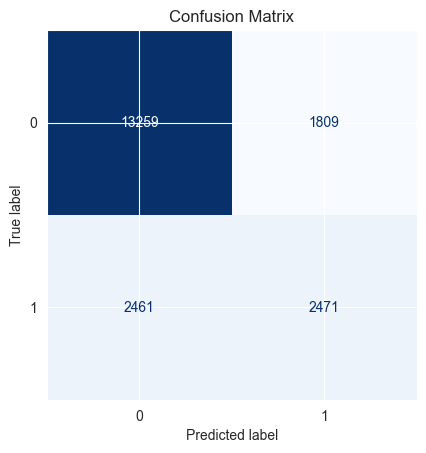

Loss: 0.5081697702407837
Classification accuracy: 81.25%


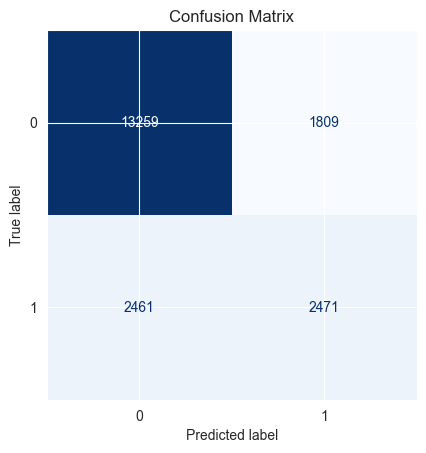

Loss: 0.46481817960739136
Classification accuracy: 85.94%


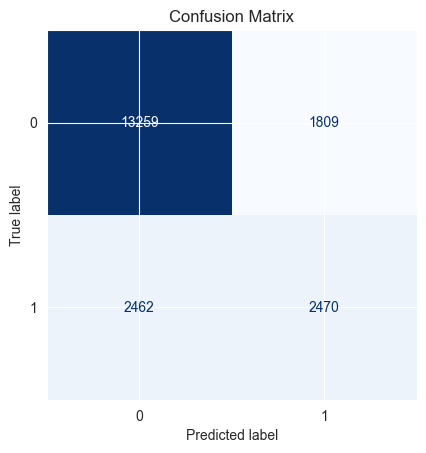

Loss: 0.48460155725479126
Classification accuracy: 81.25%


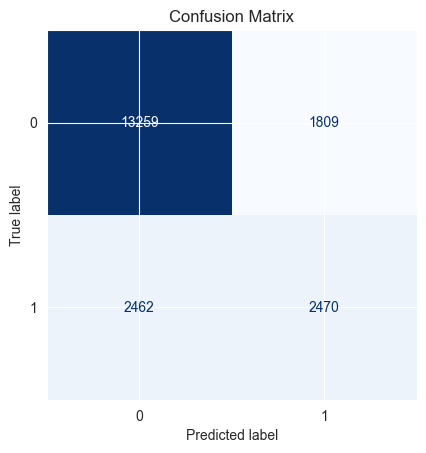

Loss: 0.5391601324081421
Classification accuracy: 76.56%


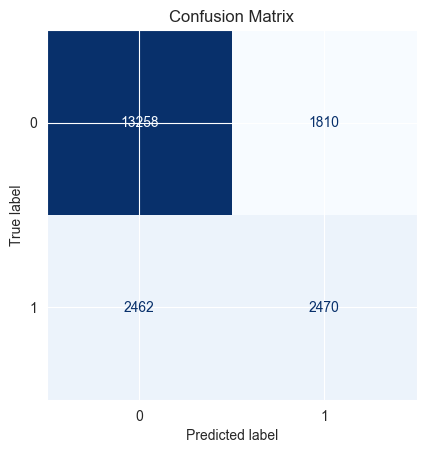

Loss: 0.5314182639122009
Classification accuracy: 76.56%


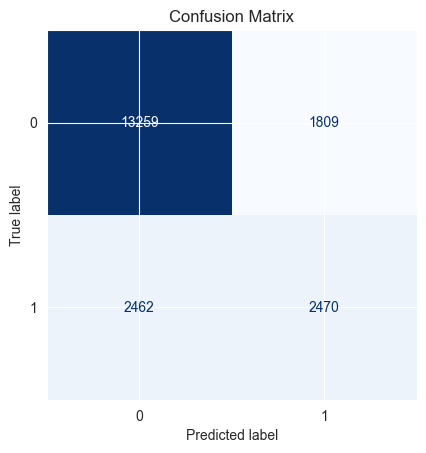

Loss: 0.5229750871658325
Classification accuracy: 79.69%


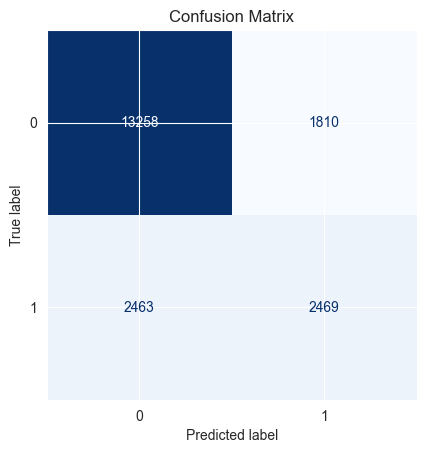

Loss: 0.47057199478149414
Classification accuracy: 84.38%


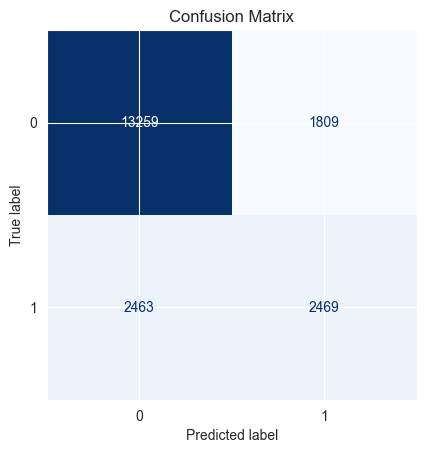

Loss: 0.5002251863479614
Classification accuracy: 81.25%


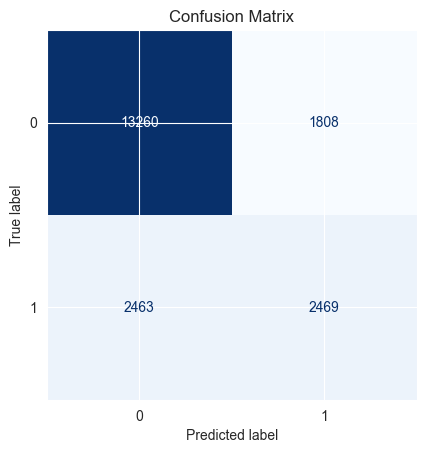

Loss: 0.4992164671421051
Classification accuracy: 79.69%


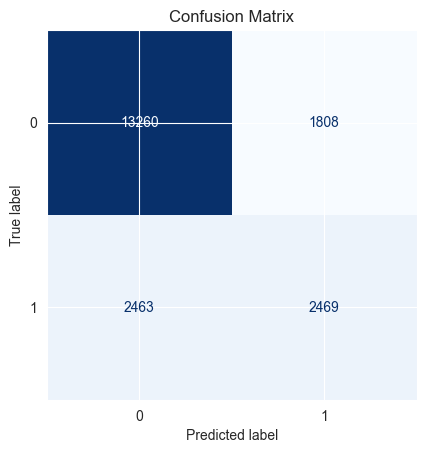

Loss: 0.4392986297607422
Classification accuracy: 87.50%


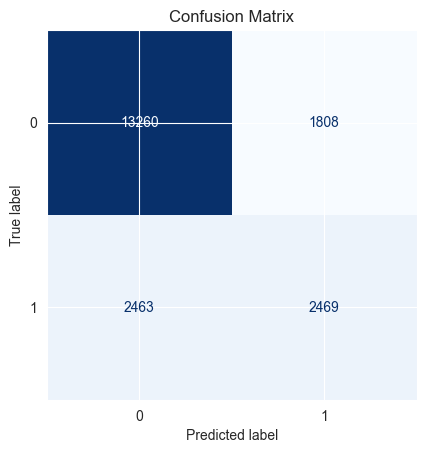

Loss: 0.4386351406574249
Classification accuracy: 87.50%


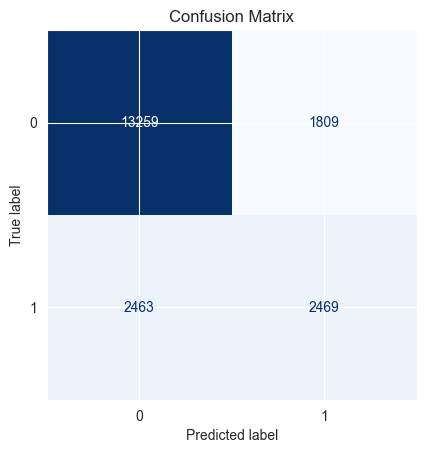

Loss: 0.4669860303401947
Classification accuracy: 84.38%


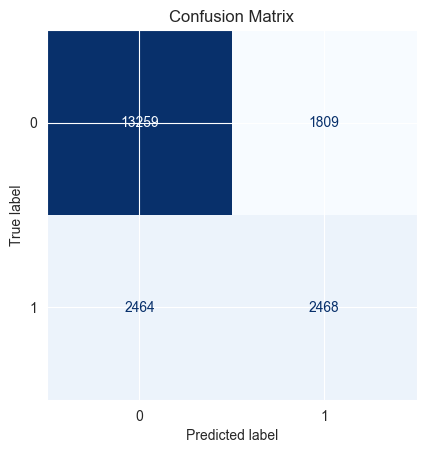

Loss: 0.42258116602897644
Classification accuracy: 87.50%


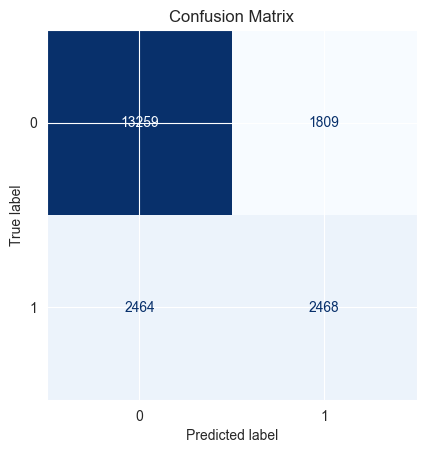

Loss: 0.4886058568954468
Classification accuracy: 82.81%


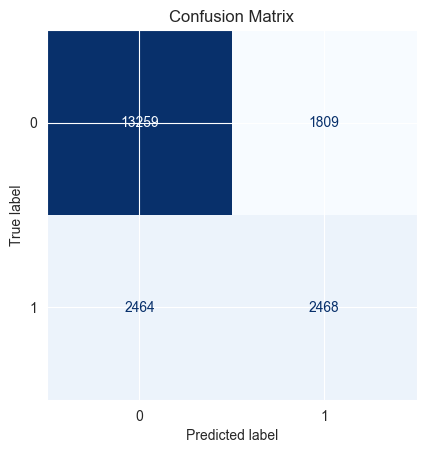

Loss: 0.44793054461479187
Classification accuracy: 85.94%


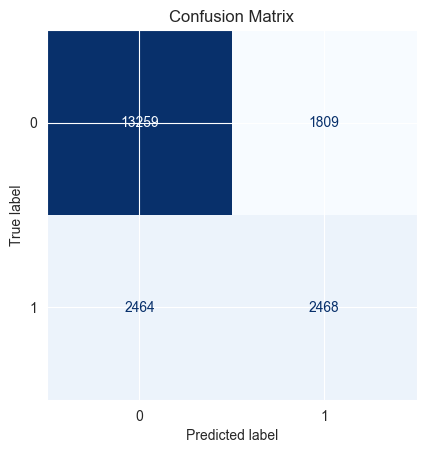

Loss: 0.5502153038978577
Classification accuracy: 73.44%


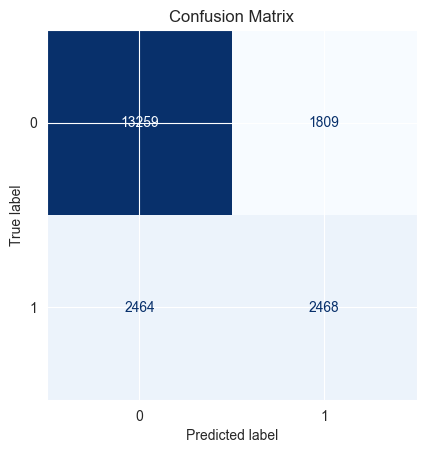

Loss: 0.503851056098938
Classification accuracy: 81.25%


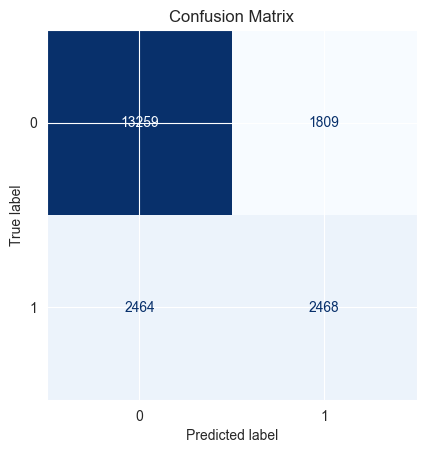

Loss: 0.44999098777770996
Classification accuracy: 85.94%


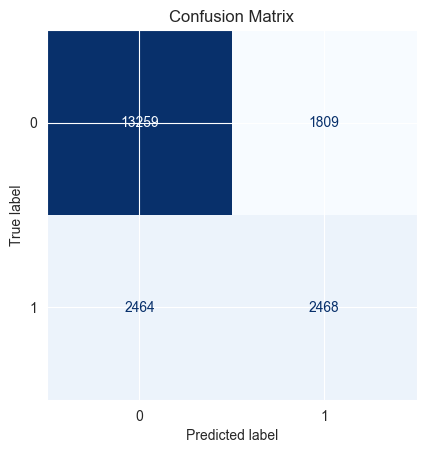

Loss: 0.5217047929763794
Classification accuracy: 78.12%


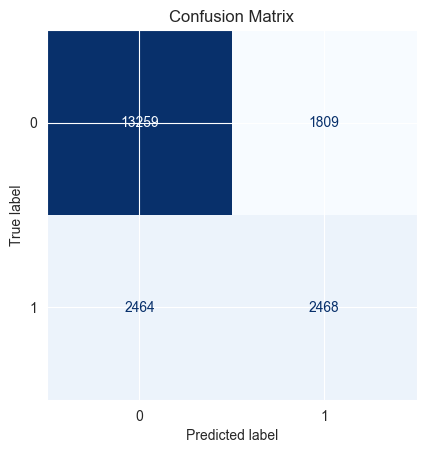

Loss: 0.5181434154510498
Classification accuracy: 78.12%


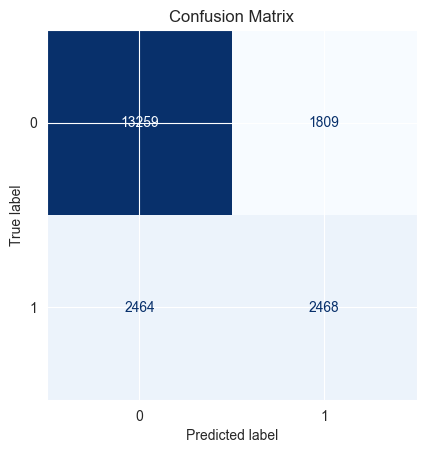

Loss: 0.509537935256958
Classification accuracy: 79.69%


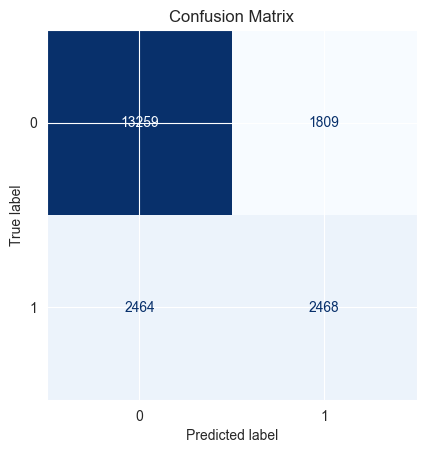

Loss: 0.5128265023231506
Classification accuracy: 78.12%


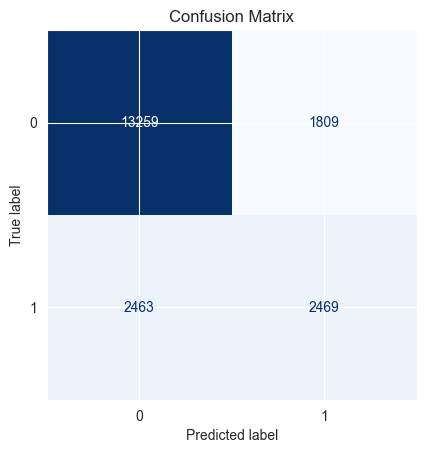

Loss: 0.4083545506000519
Classification accuracy: 92.19%


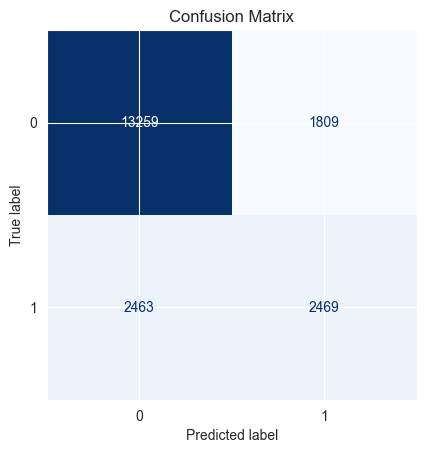

Loss: 0.5356481075286865
Classification accuracy: 76.56%


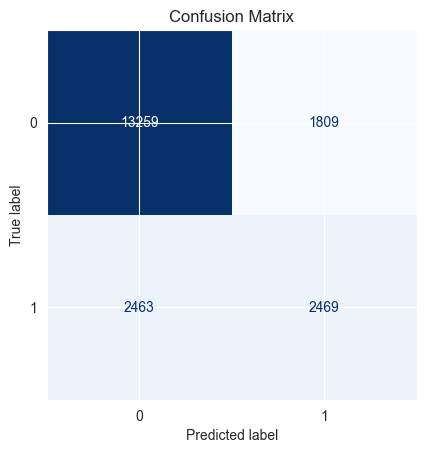

Loss: 0.5066240429878235
Classification accuracy: 78.12%


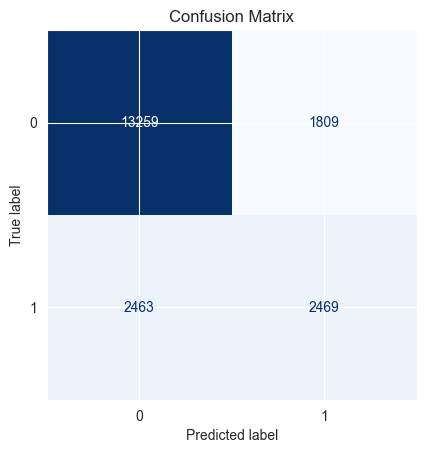

Loss: 0.5798773765563965
Classification accuracy: 71.88%


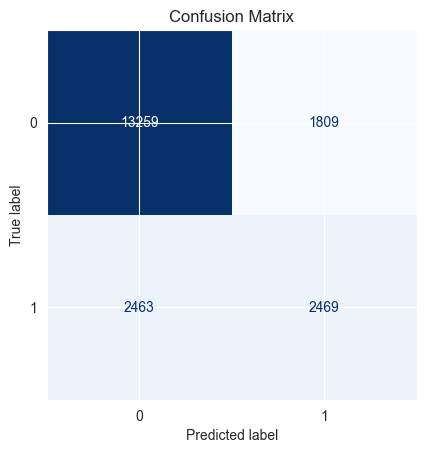

Loss: 0.531089186668396
Classification accuracy: 75.00%


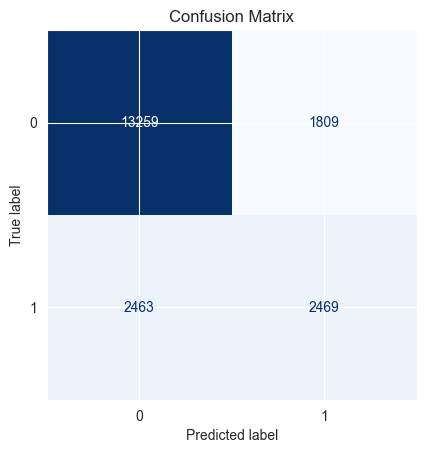

Loss: 0.456745445728302
Classification accuracy: 85.94%


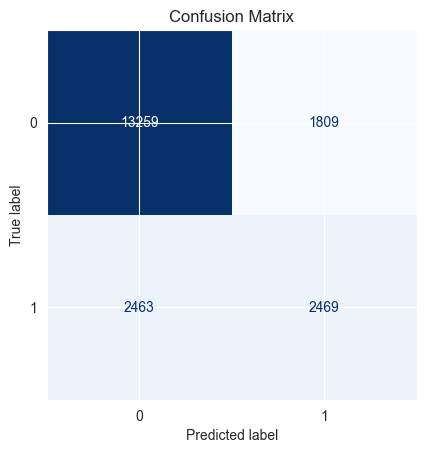

Loss: 0.40951818227767944
Classification accuracy: 90.62%


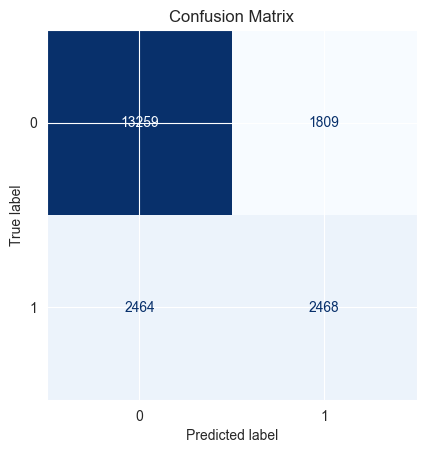

Loss: 0.4794435203075409
Classification accuracy: 82.81%


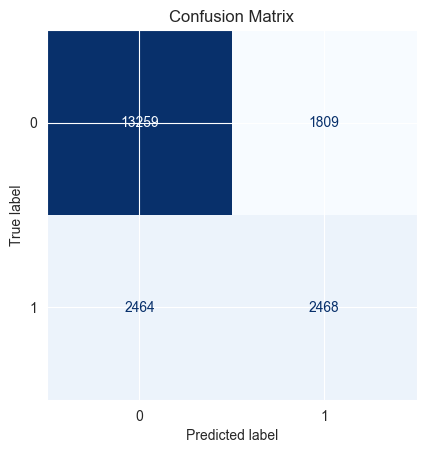

Loss: 0.4690394103527069
Classification accuracy: 85.94%


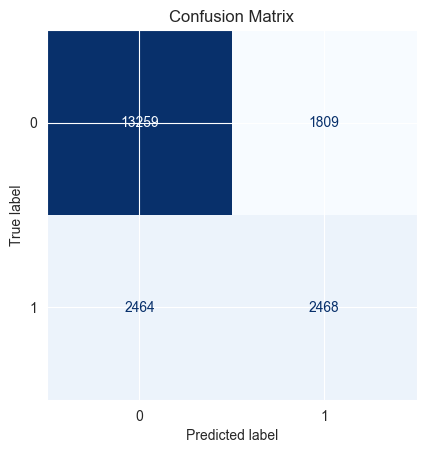

Loss: 0.5178062319755554
Classification accuracy: 78.12%


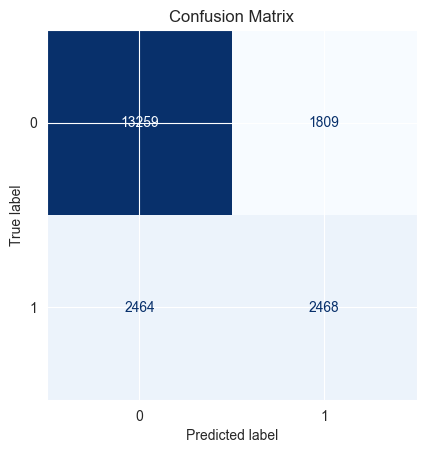

Loss: 0.5459849238395691
Classification accuracy: 75.00%


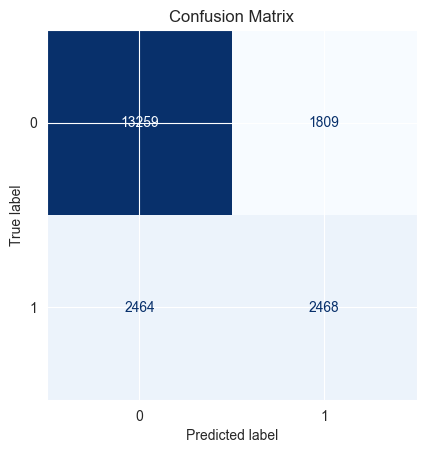

Loss: 0.4484556317329407
Classification accuracy: 87.50%


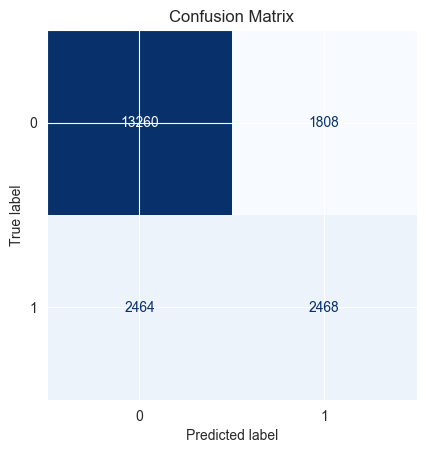

Loss: 0.45869776606559753
Classification accuracy: 84.38%


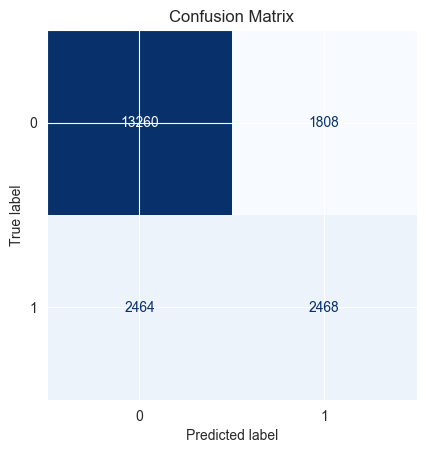

Loss: 0.5490697622299194
Classification accuracy: 75.00%


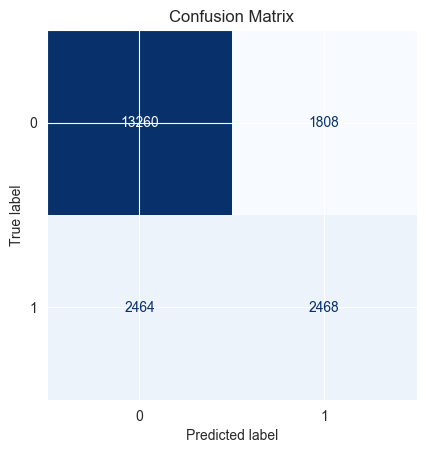

Loss: 0.4994412660598755
Classification accuracy: 79.69%


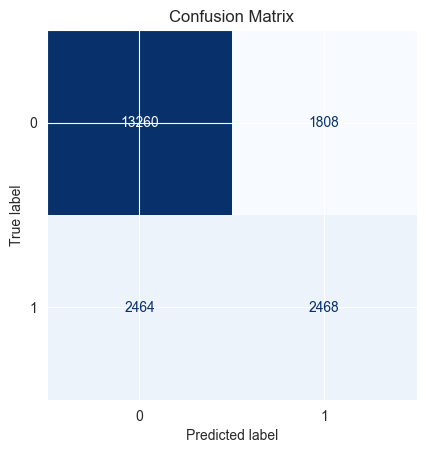

Loss: 0.5630965232849121
Classification accuracy: 75.00%


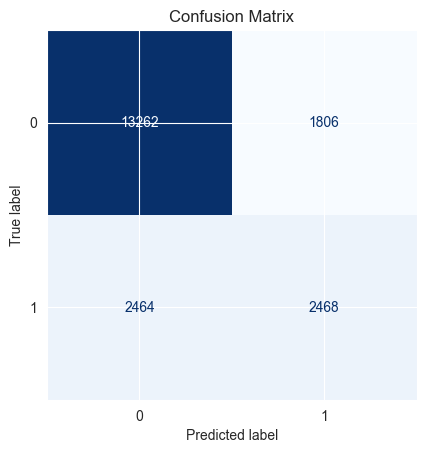

Loss: 0.45667797327041626
Classification accuracy: 85.94%


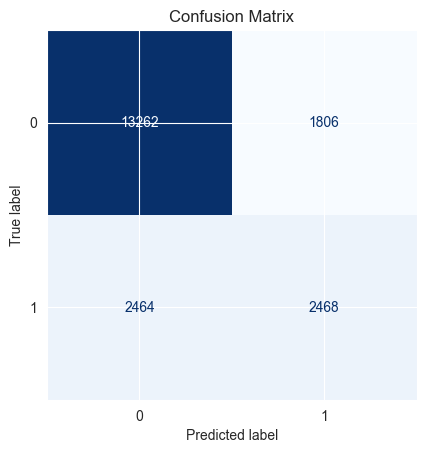

Loss: 0.44969943165779114
Classification accuracy: 85.94%


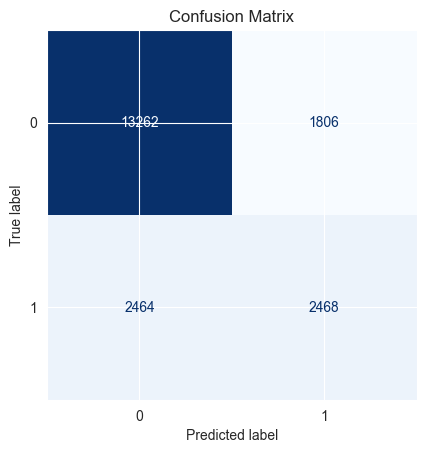

Loss: 0.49170103669166565
Classification accuracy: 79.69%


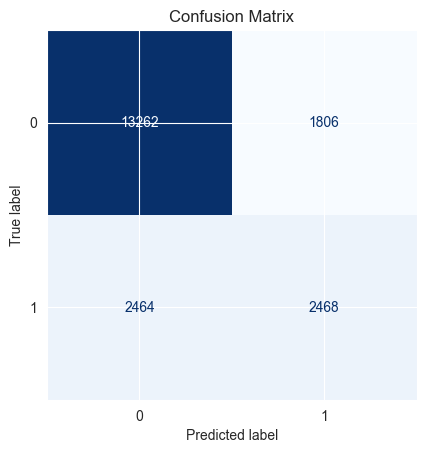

Loss: 0.47112348675727844
Classification accuracy: 84.38%


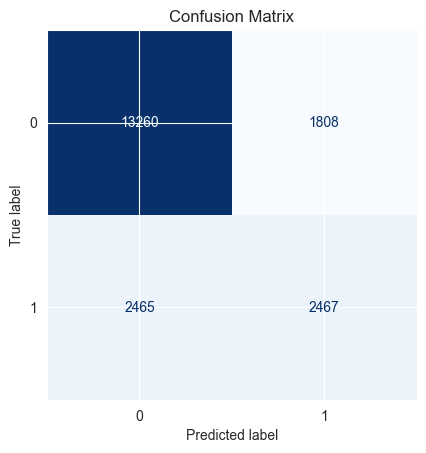

Loss: 0.48696815967559814
Classification accuracy: 82.81%


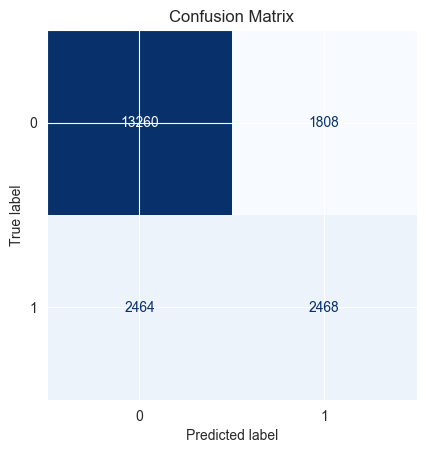

Loss: 0.4594655930995941
Classification accuracy: 84.38%


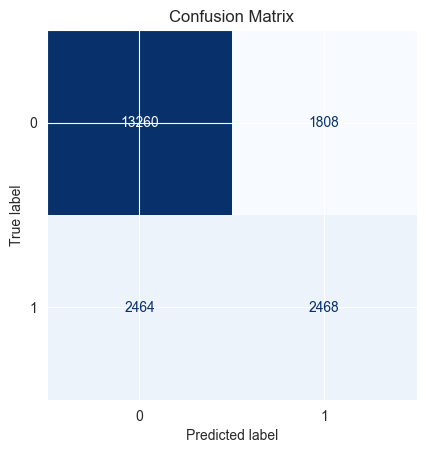

Loss: 0.4671801030635834
Classification accuracy: 84.38%


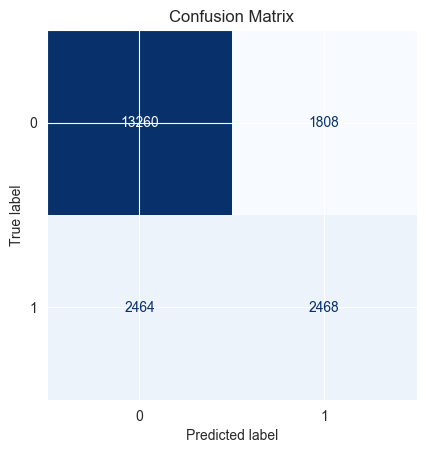

Loss: 0.49085450172424316
Classification accuracy: 81.25%


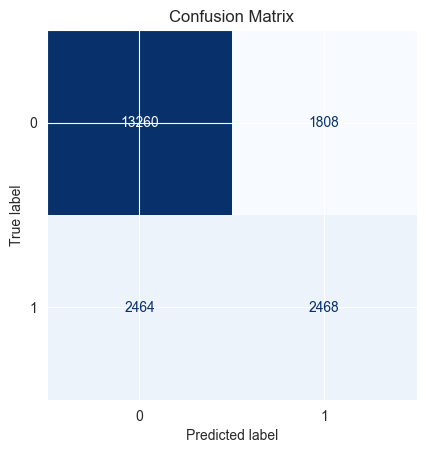

Loss: 0.48461252450942993
Classification accuracy: 81.25%


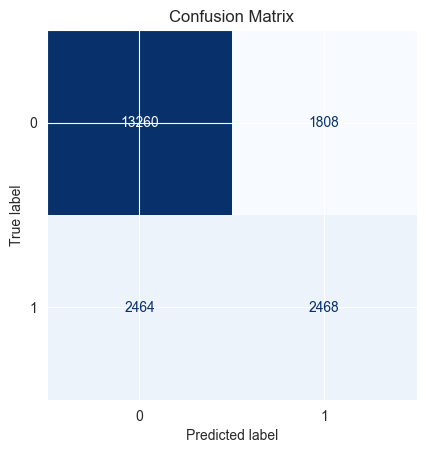

Loss: 0.4411907494068146
Classification accuracy: 87.50%


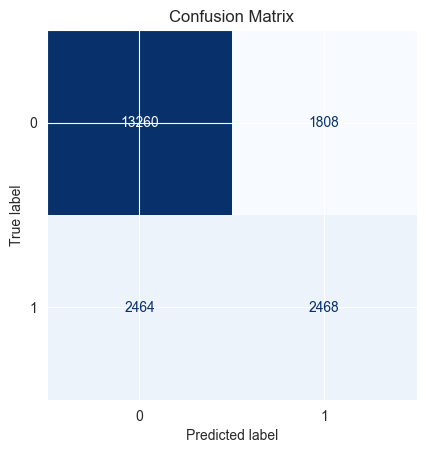

Loss: 0.46125921607017517
Classification accuracy: 85.94%


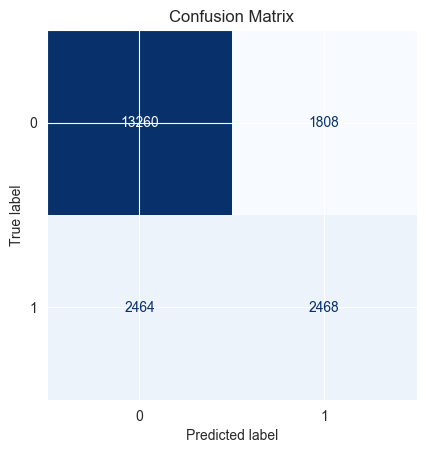

Loss: 0.5200763940811157
Classification accuracy: 79.69%


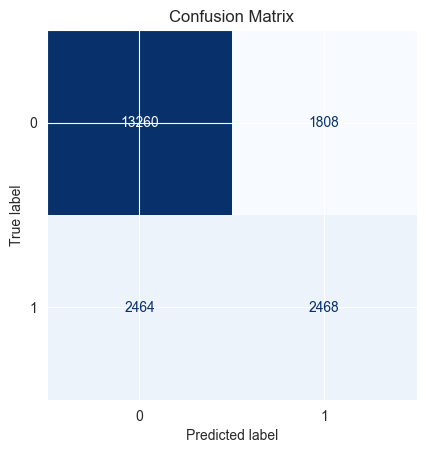

Loss: 0.4322190582752228
Classification accuracy: 87.50%


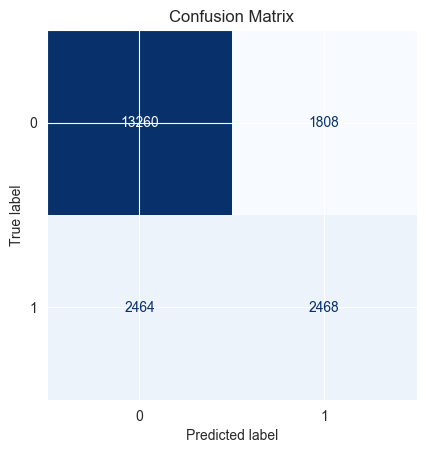

Loss: 0.5176315903663635
Classification accuracy: 79.69%


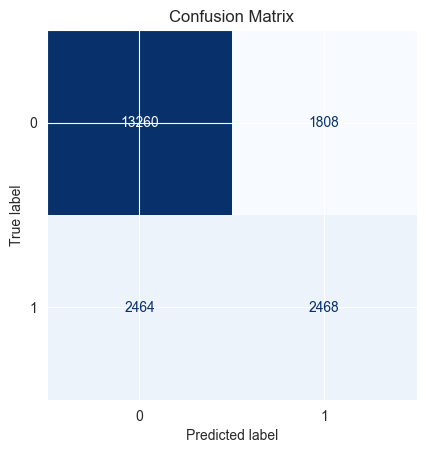

Loss: 0.5020574927330017
Classification accuracy: 81.25%


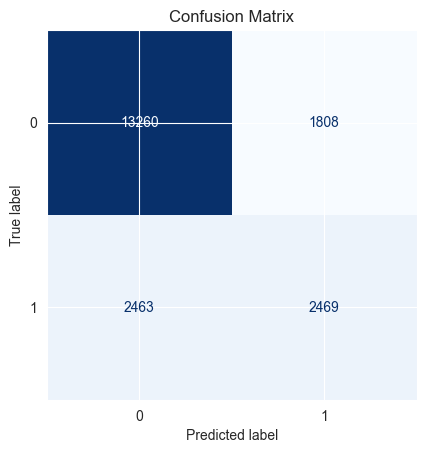

Loss: 0.5329068303108215
Classification accuracy: 76.56%


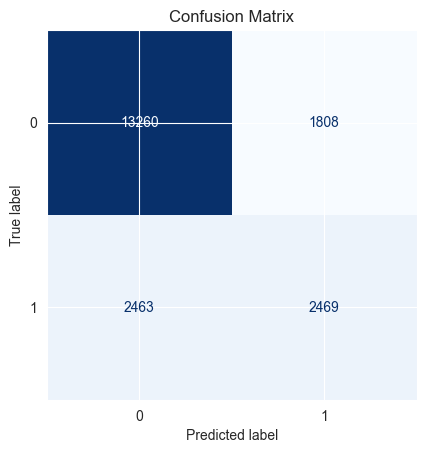

Loss: 0.4389124810695648
Classification accuracy: 87.50%


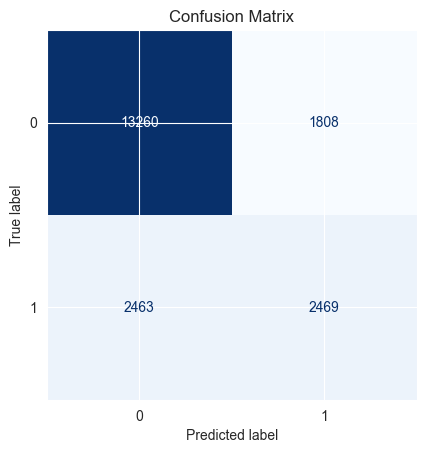

Loss: 0.5787010788917542
Classification accuracy: 73.44%


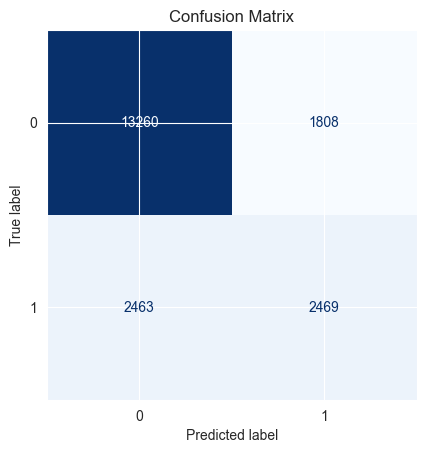

Loss: 0.484552800655365
Classification accuracy: 82.81%


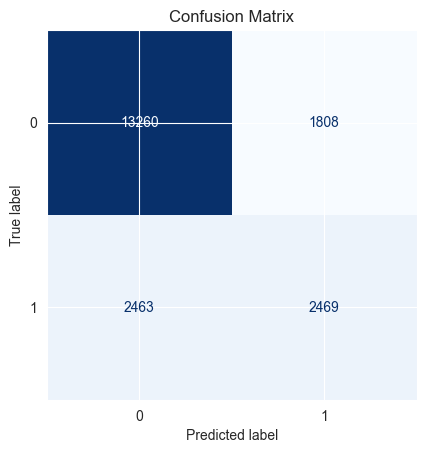

Loss: 0.4521094262599945
Classification accuracy: 85.94%


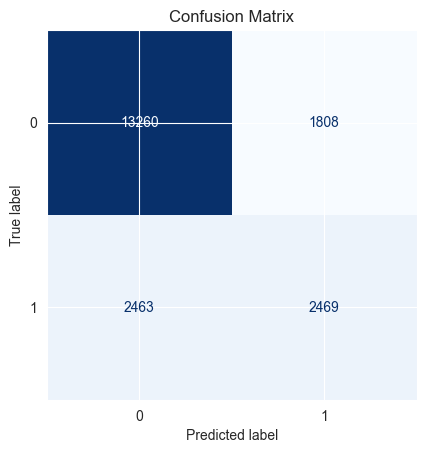

Loss: 0.4544173777103424
Classification accuracy: 85.94%


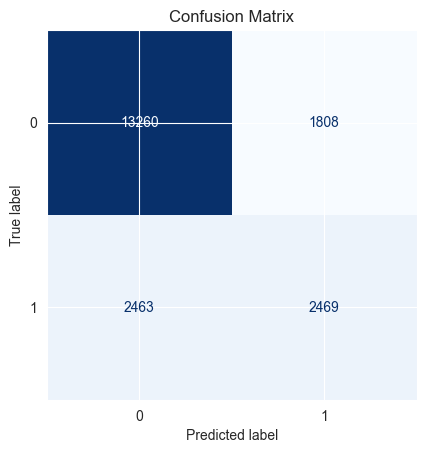

Loss: 0.5371661186218262
Classification accuracy: 79.69%


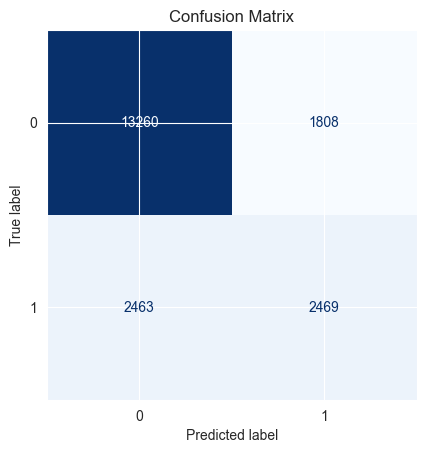

Loss: 0.45844313502311707
Classification accuracy: 87.50%


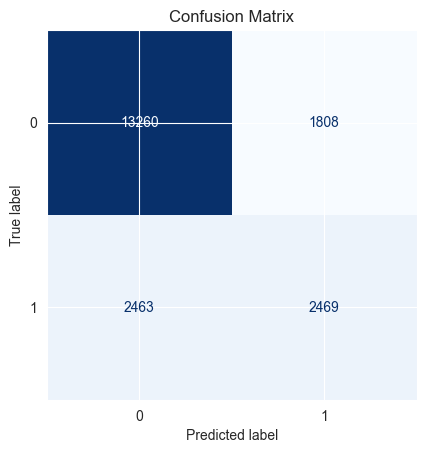

Loss: 0.5066401958465576
Classification accuracy: 78.12%


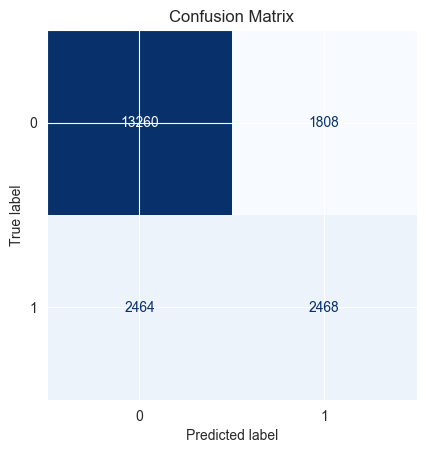

Loss: 0.4230812191963196
Classification accuracy: 89.06%


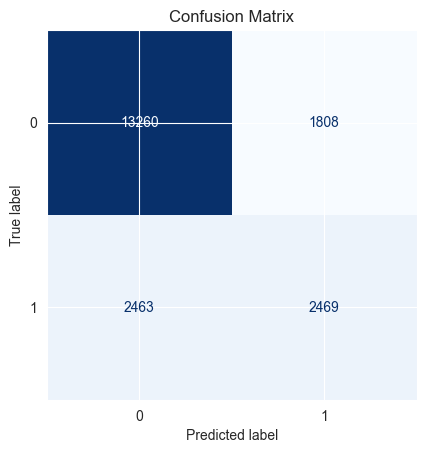

Loss: 0.4296155869960785
Classification accuracy: 89.06%


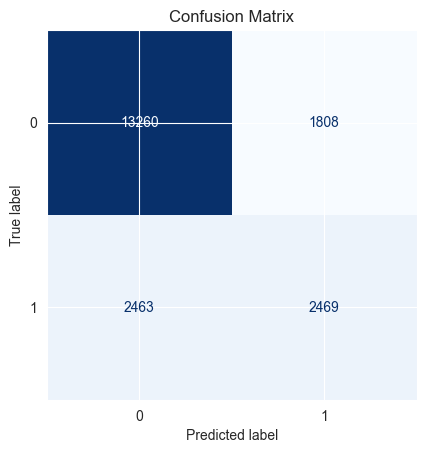

Loss: 0.39772292971611023
Classification accuracy: 92.19%


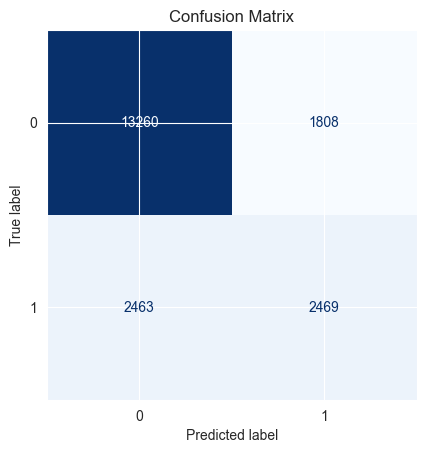

Loss: 0.4544386863708496
Classification accuracy: 84.38%


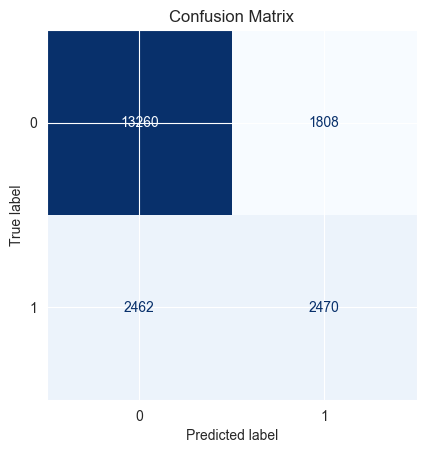

Loss: 0.4410010874271393
Classification accuracy: 87.50%


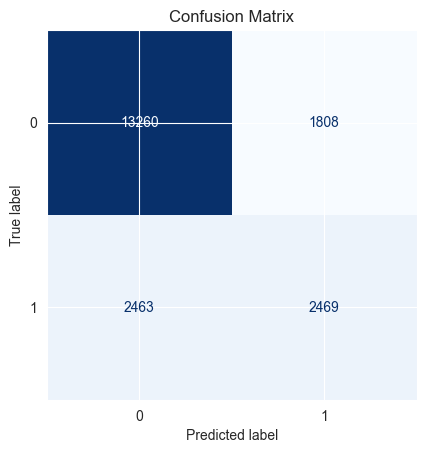

Loss: 0.5266653895378113
Classification accuracy: 78.12%


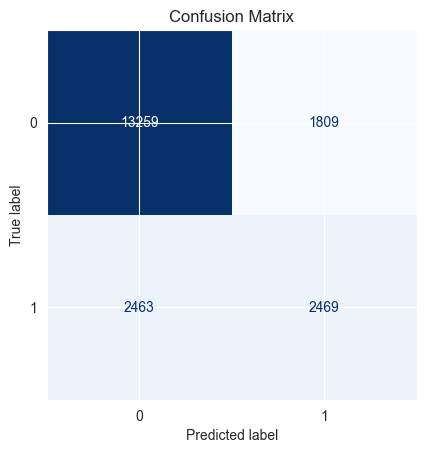

Loss: 0.5033921599388123
Classification accuracy: 81.25%


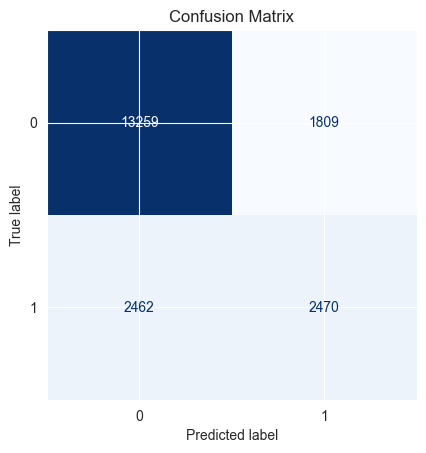

Loss: 0.4832786023616791
Classification accuracy: 81.25%


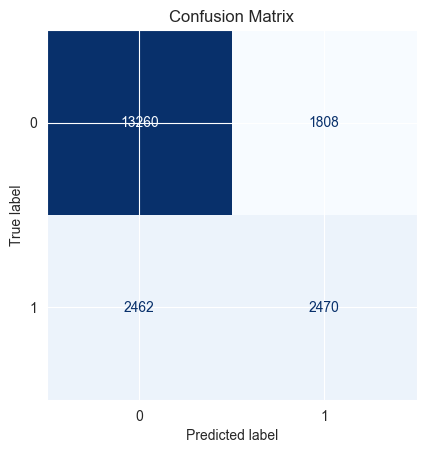

Loss: 0.5268236398696899
Classification accuracy: 78.12%


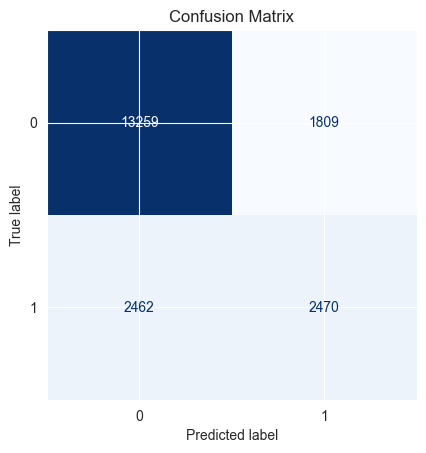

Loss: 0.4307717978954315
Classification accuracy: 89.06%


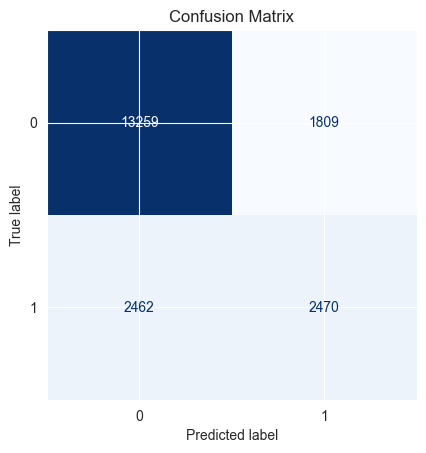

Loss: 0.5516846179962158
Classification accuracy: 75.00%


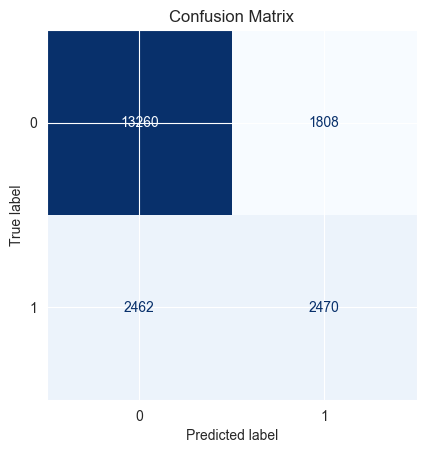

Loss: 0.4334152340888977
Classification accuracy: 89.06%


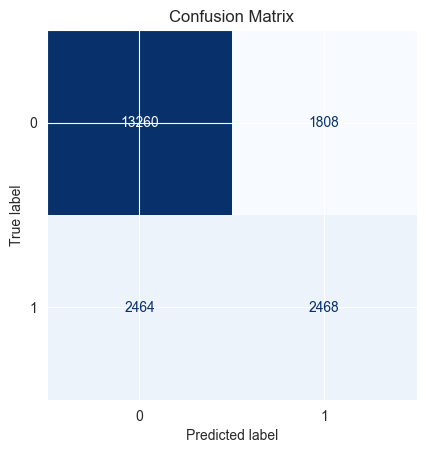

Loss: 0.5548895001411438
Classification accuracy: 76.56%


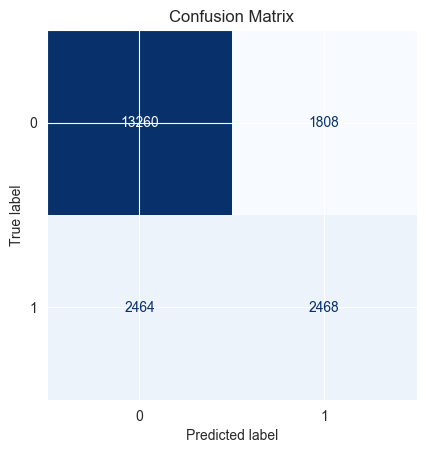

Loss: 0.5728855133056641
Classification accuracy: 71.88%


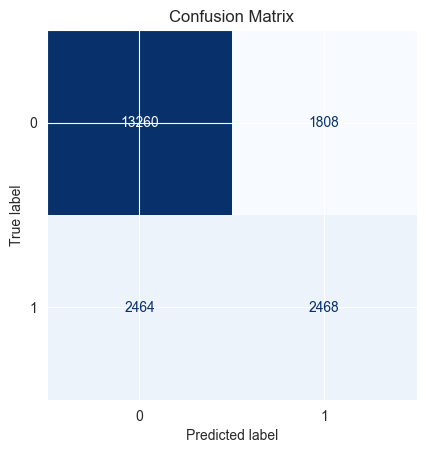

Loss: 0.534905731678009
Classification accuracy: 76.56%


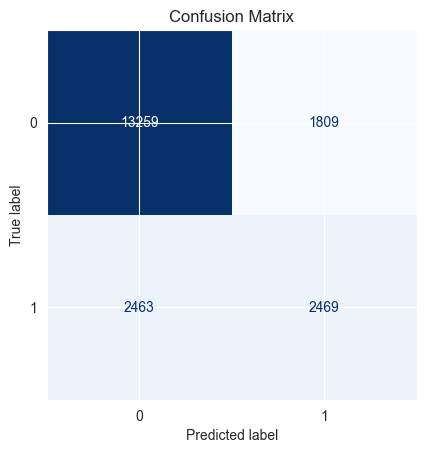

Loss: 0.5707730054855347
Classification accuracy: 71.88%


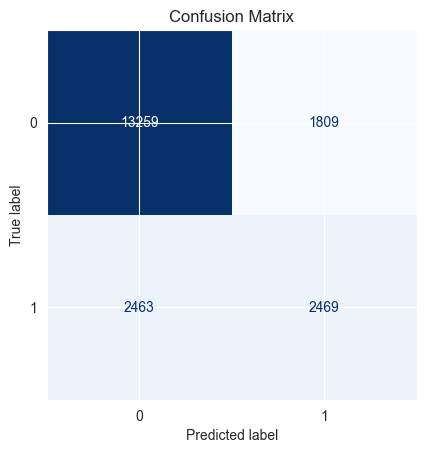

Loss: 0.4619186520576477
Classification accuracy: 82.81%


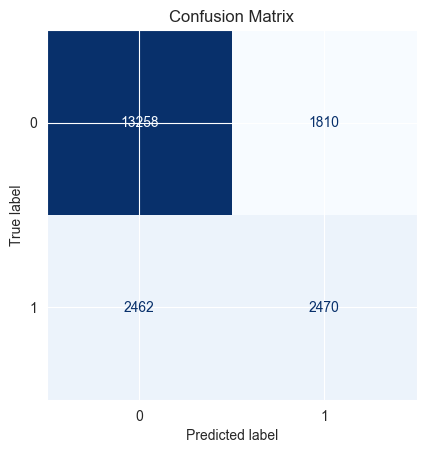

Loss: 0.5141605734825134
Classification accuracy: 81.25%


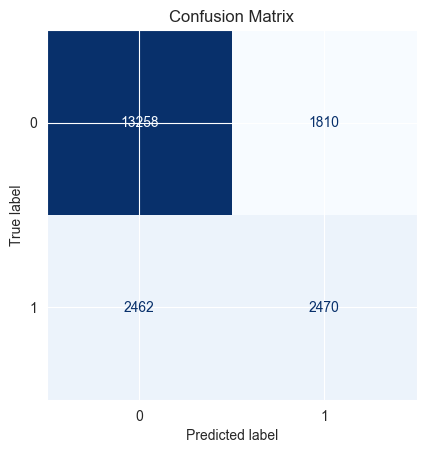

Loss: 0.43292734026908875
Classification accuracy: 87.50%


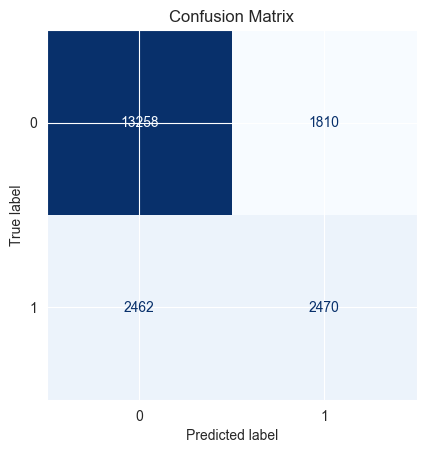

Loss: 0.45429667830467224
Classification accuracy: 85.94%


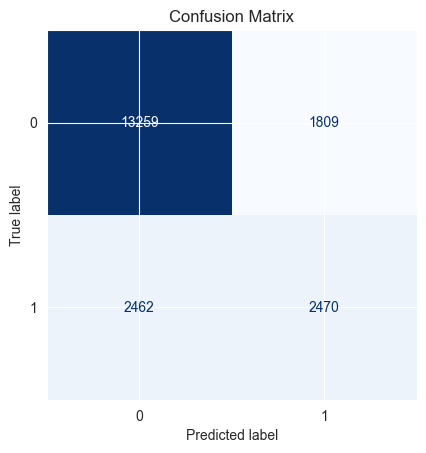

Loss: 0.5038753747940063
Classification accuracy: 79.69%


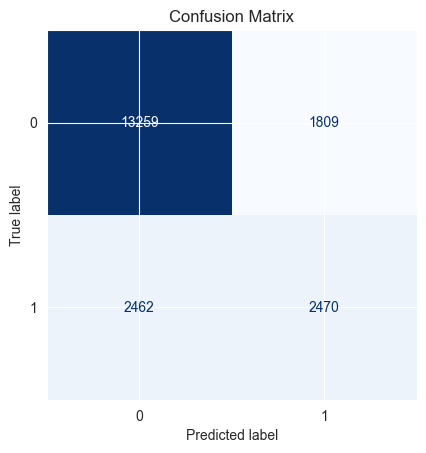

Loss: 0.4885924458503723
Classification accuracy: 82.81%


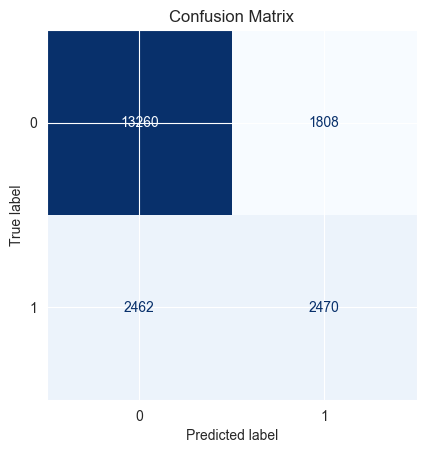

Loss: 0.48629745841026306
Classification accuracy: 81.25%


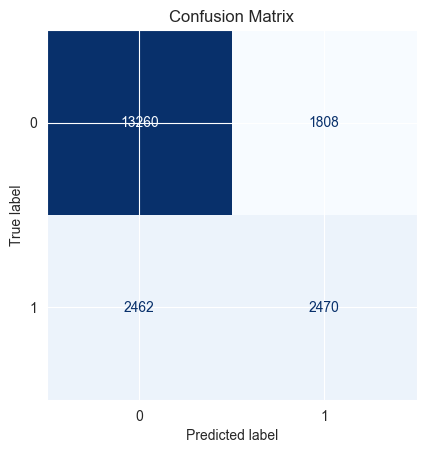

Loss: 0.48510465025901794
Classification accuracy: 84.38%


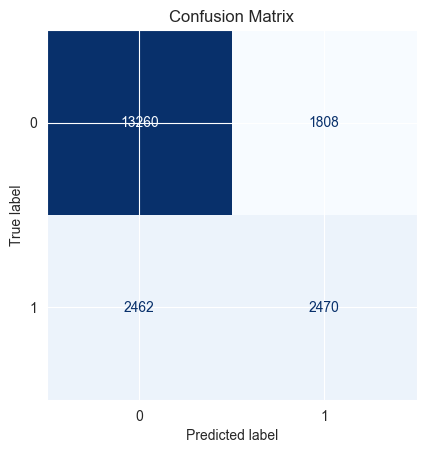

Loss: 0.5495306253433228
Classification accuracy: 73.44%


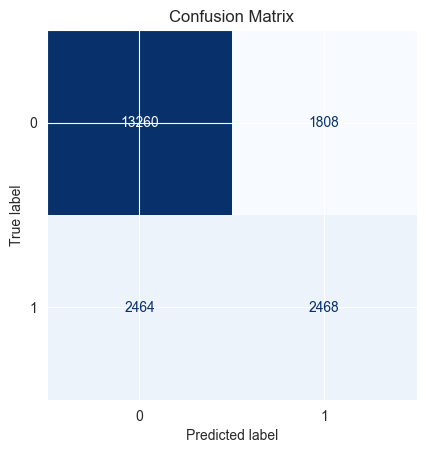

Loss: 0.4653836488723755
Classification accuracy: 84.38%


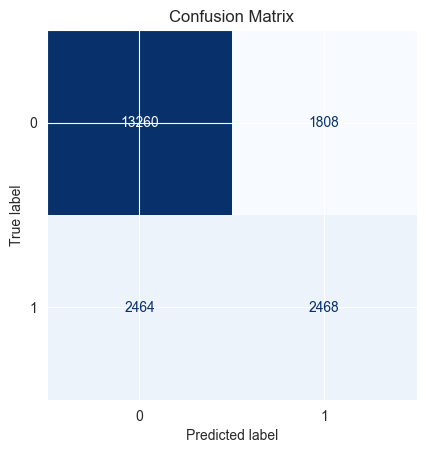

Loss: 0.4440732002258301
Classification accuracy: 87.50%


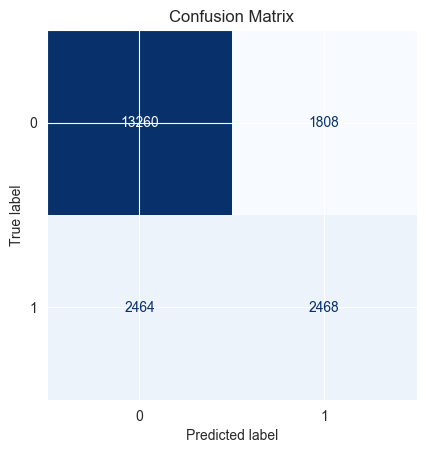

Loss: 0.5062164068222046
Classification accuracy: 78.12%


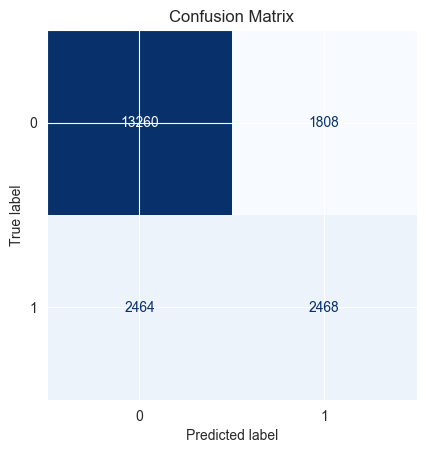

Loss: 0.5045871734619141
Classification accuracy: 82.81%


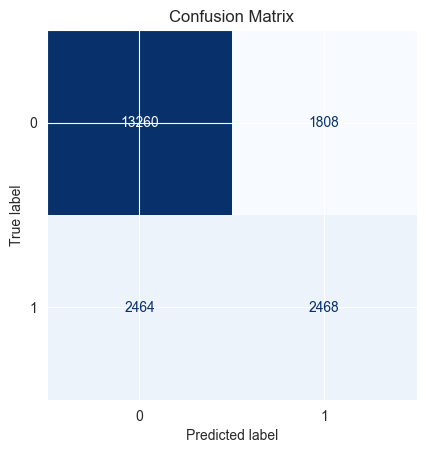

Loss: 0.4477391839027405
Classification accuracy: 85.94%


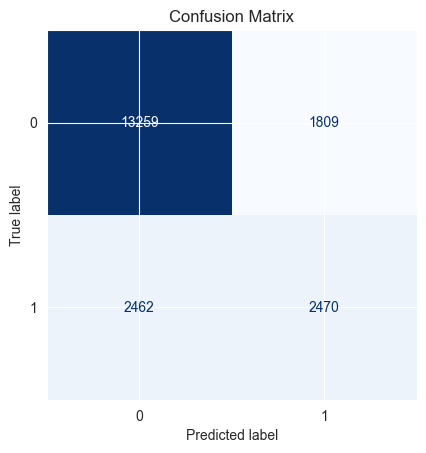

Loss: 0.521155595779419
Classification accuracy: 78.12%


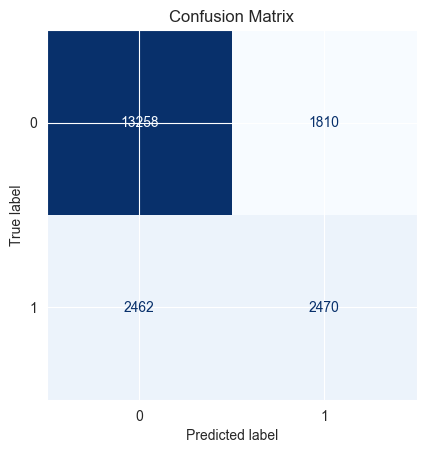

Loss: 0.5530003309249878
Classification accuracy: 76.56%


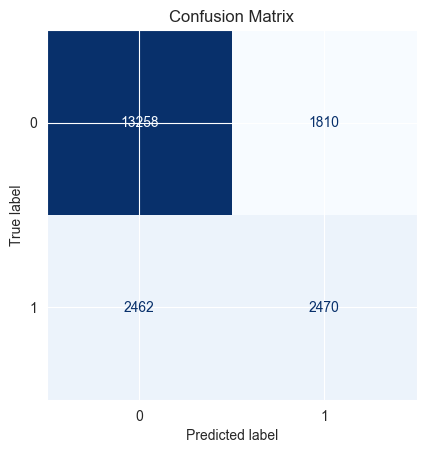

Loss: 0.5226355195045471
Classification accuracy: 76.56%


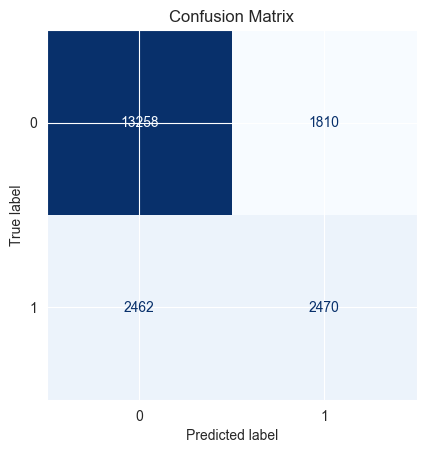

Loss: 0.45308372378349304
Classification accuracy: 84.38%


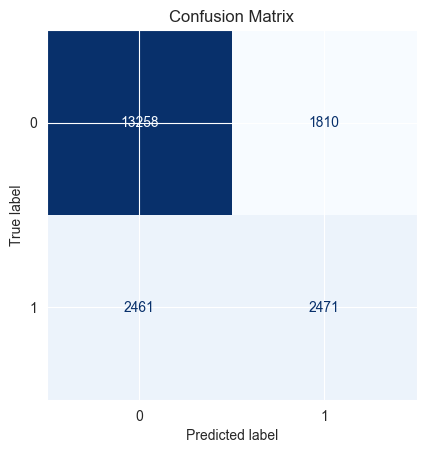

Loss: 0.4384327828884125
Classification accuracy: 87.50%


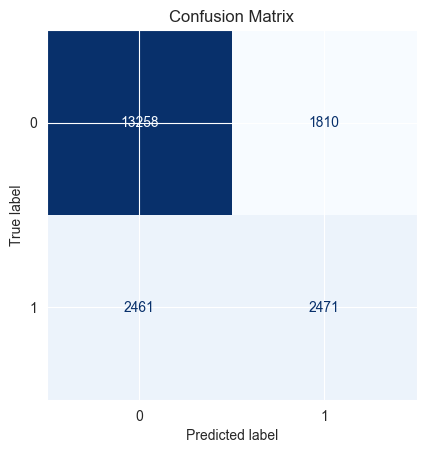

Loss: 0.5149422287940979
Classification accuracy: 78.12%


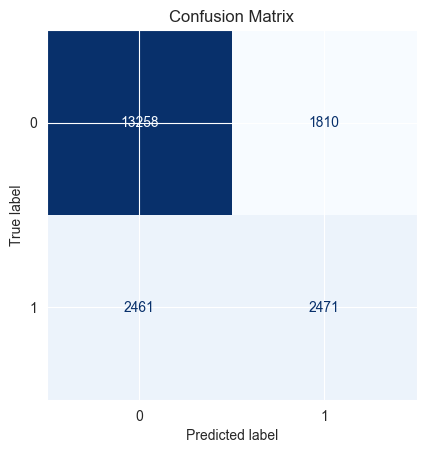

Loss: 0.4880630671977997
Classification accuracy: 84.38%


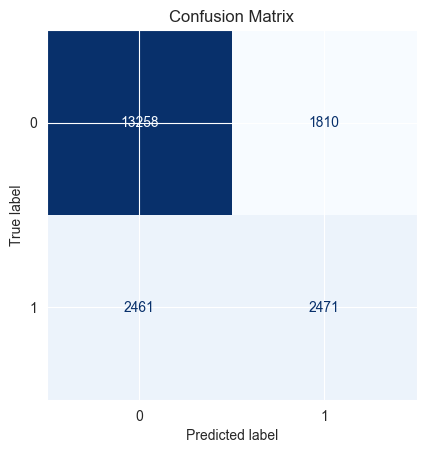

Loss: 0.5131183862686157
Classification accuracy: 79.69%


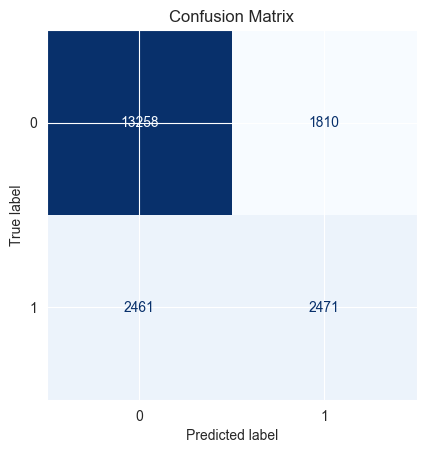

Loss: 0.4894642233848572
Classification accuracy: 82.81%


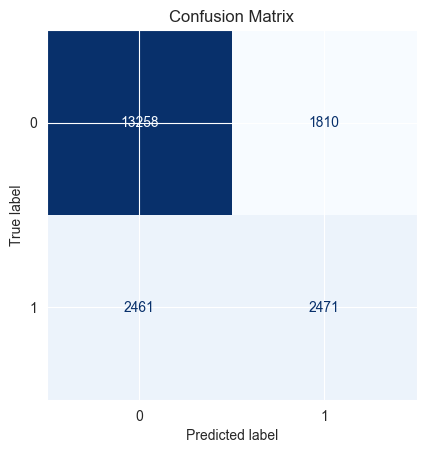

Loss: 0.42392006516456604
Classification accuracy: 89.06%


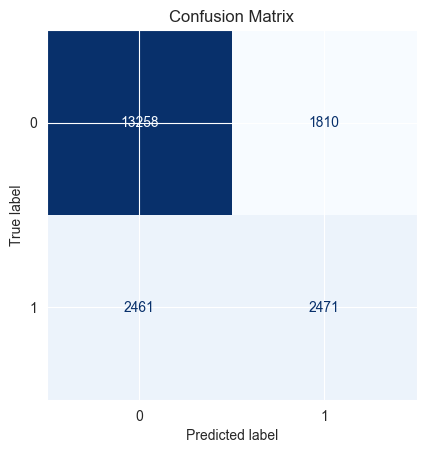

Loss: 0.45528745651245117
Classification accuracy: 87.50%


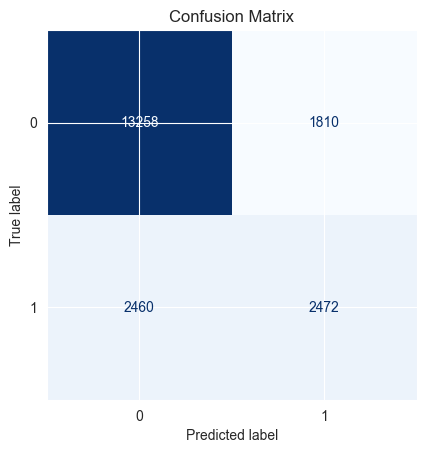

Loss: 0.5256005525588989
Classification accuracy: 79.69%


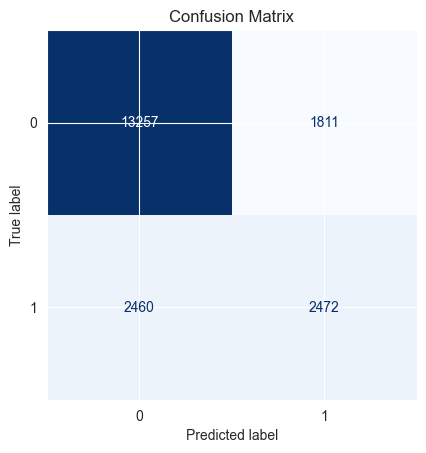

Loss: 0.5453211069107056
Classification accuracy: 73.44%


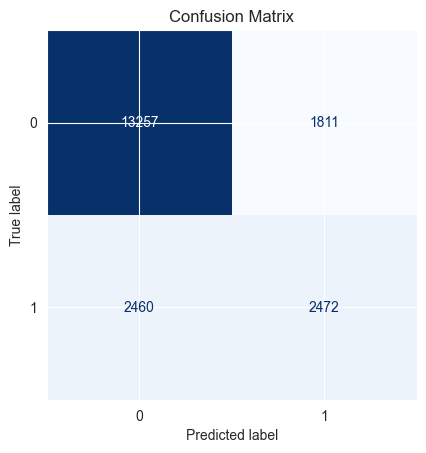

Loss: 0.5826101303100586
Classification accuracy: 73.44%


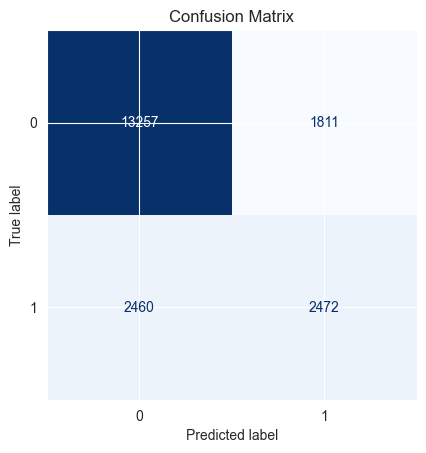

Loss: 0.45635947585105896
Classification accuracy: 84.38%


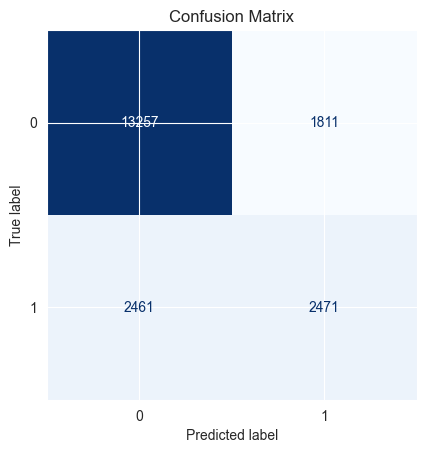

Loss: 0.46266570687294006
Classification accuracy: 84.38%


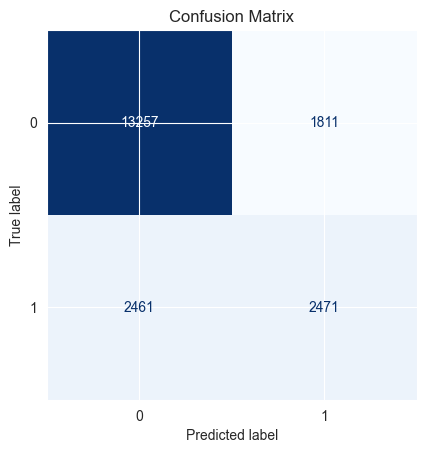

Loss: 0.47433826327323914
Classification accuracy: 81.25%


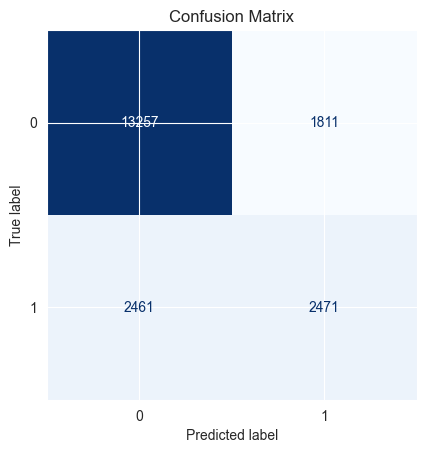

Loss: 0.5302637219429016
Classification accuracy: 78.12%


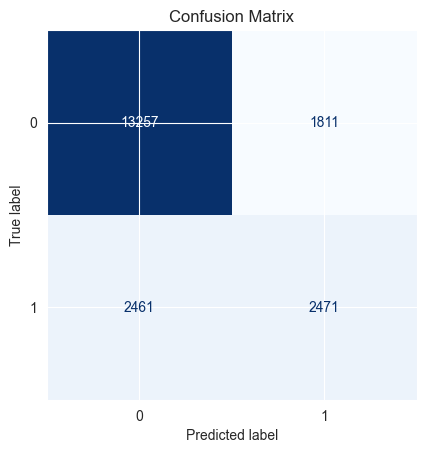

Loss: 0.5053243637084961
Classification accuracy: 79.69%


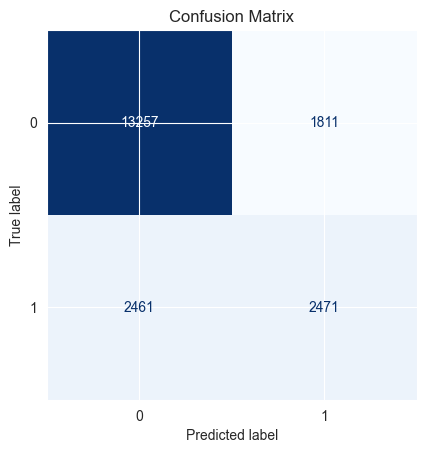

Loss: 0.5342119336128235
Classification accuracy: 76.56%


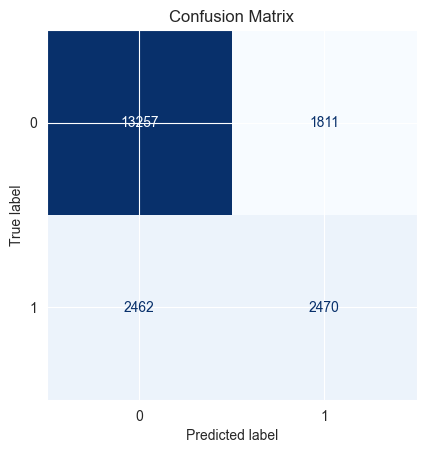

Loss: 0.5213640332221985
Classification accuracy: 76.56%


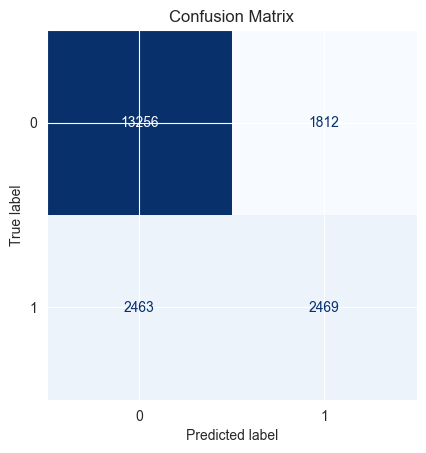

Loss: 0.5353316068649292
Classification accuracy: 76.56%


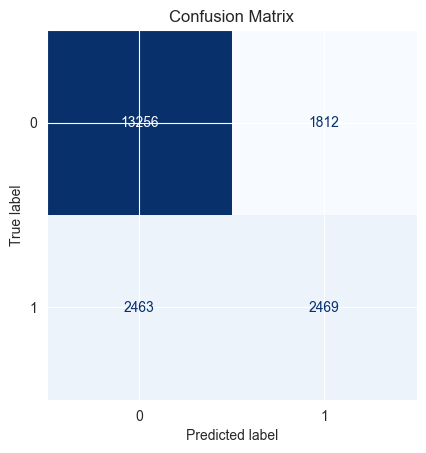

Loss: 0.4935356676578522
Classification accuracy: 81.25%


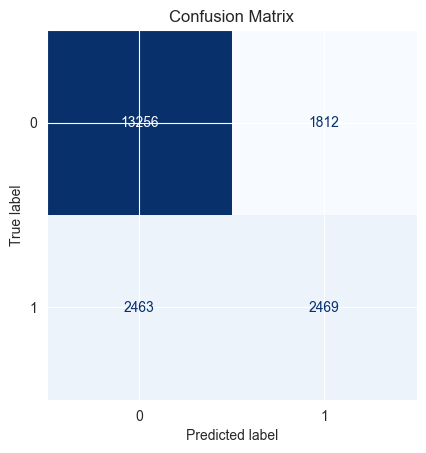

Loss: 0.45503145456314087
Classification accuracy: 85.94%


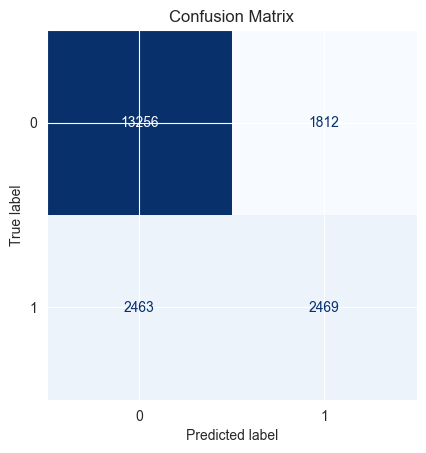

Loss: 0.46743863821029663
Classification accuracy: 85.94%


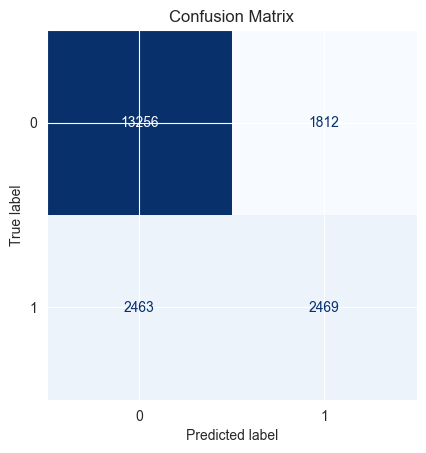

Loss: 0.46180635690689087
Classification accuracy: 81.25%


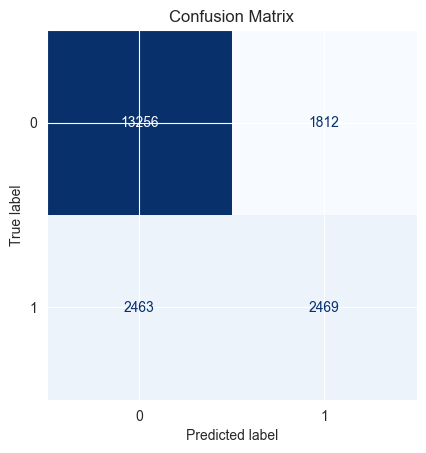

Loss: 0.5239260196685791
Classification accuracy: 78.12%


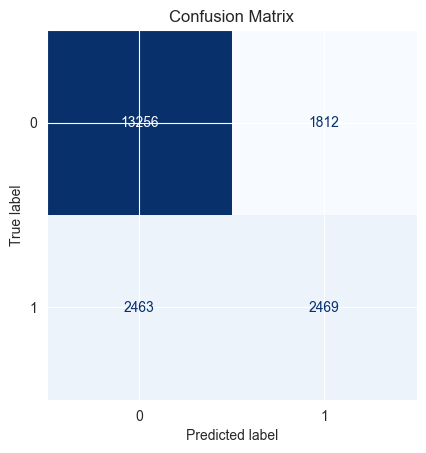

Loss: 0.5059423446655273
Classification accuracy: 79.69%


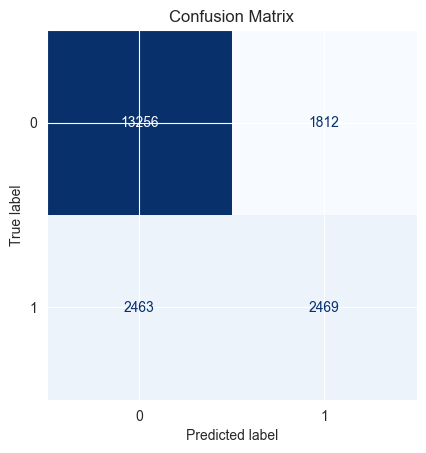

Loss: 0.41064557433128357
Classification accuracy: 90.62%


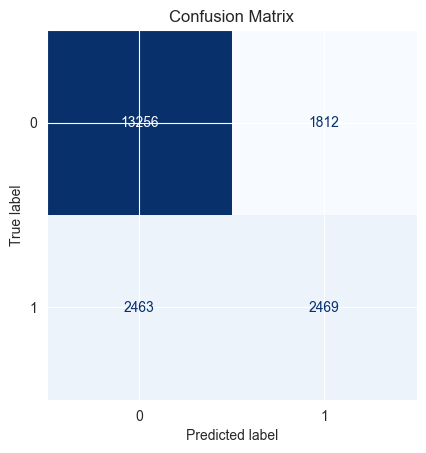

Loss: 0.46127262711524963
Classification accuracy: 84.38%


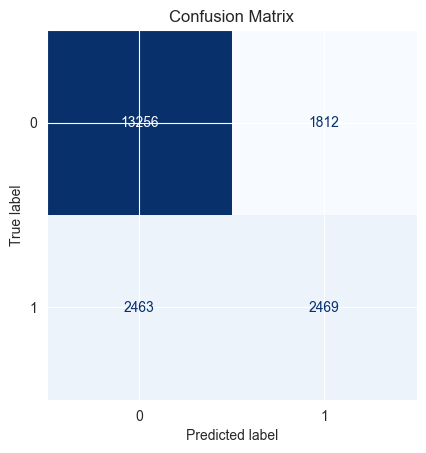

Loss: 0.54261314868927
Classification accuracy: 78.12%


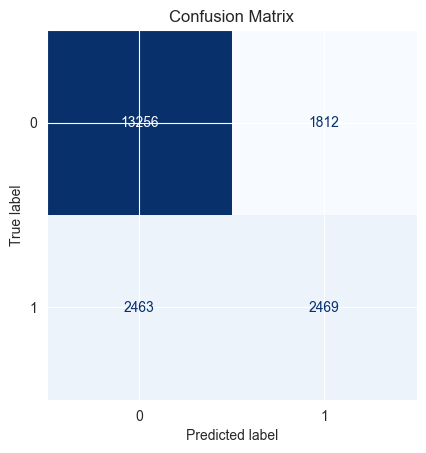

Loss: 0.47562041878700256
Classification accuracy: 82.81%


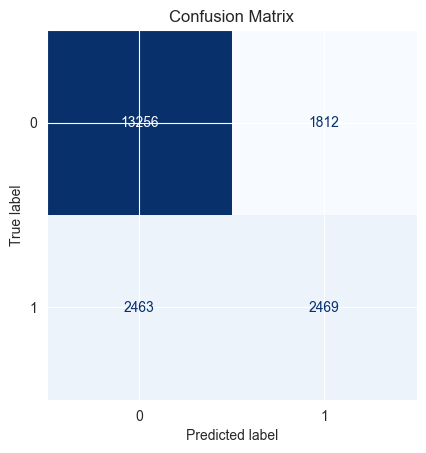

Loss: 0.52882981300354
Classification accuracy: 75.00%


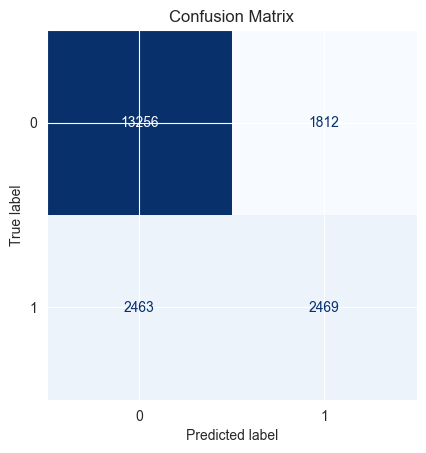

Loss: 0.49267444014549255
Classification accuracy: 81.25%


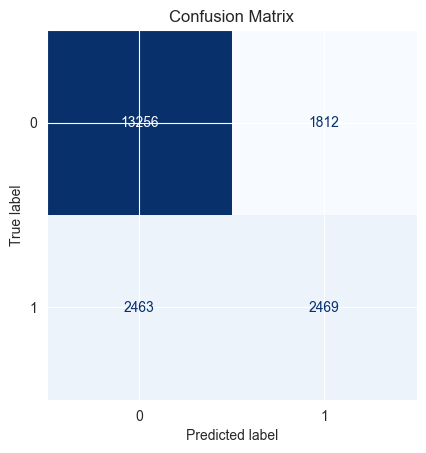

Loss: 0.42430248856544495
Classification accuracy: 87.50%


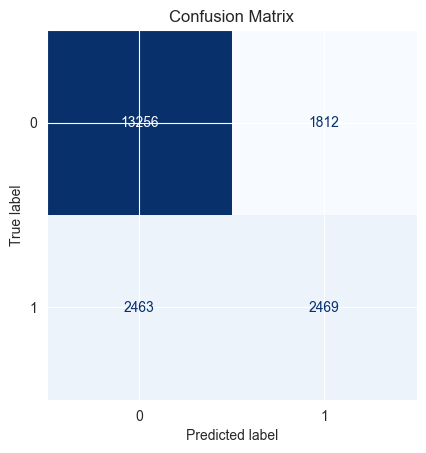

Loss: 0.4908113181591034
Classification accuracy: 84.38%


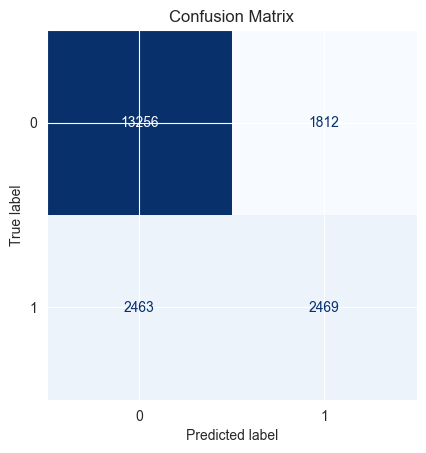

Loss: 0.4356898069381714
Classification accuracy: 89.06%


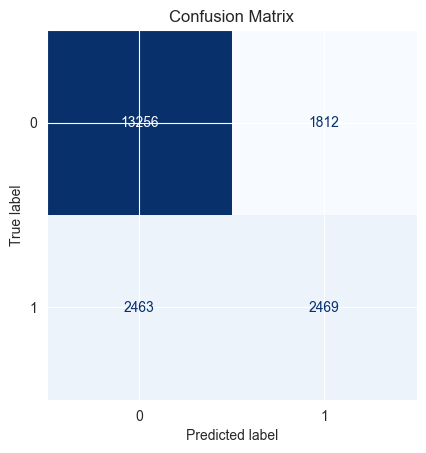

Loss: 0.44337010383605957
Classification accuracy: 87.50%


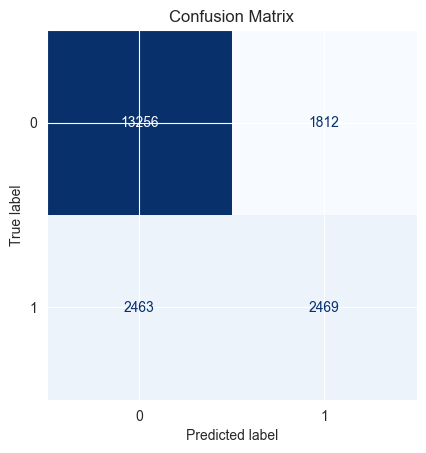

Loss: 0.4552925229072571
Classification accuracy: 84.38%


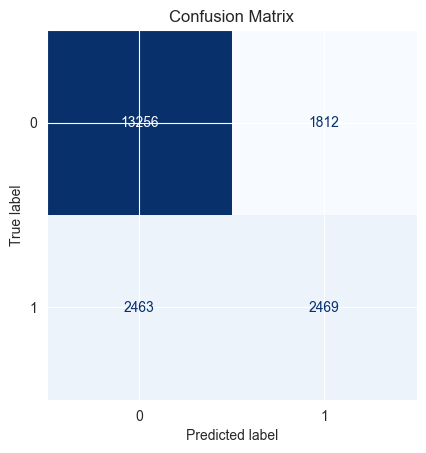

Loss: 0.478184312582016
Classification accuracy: 82.81%


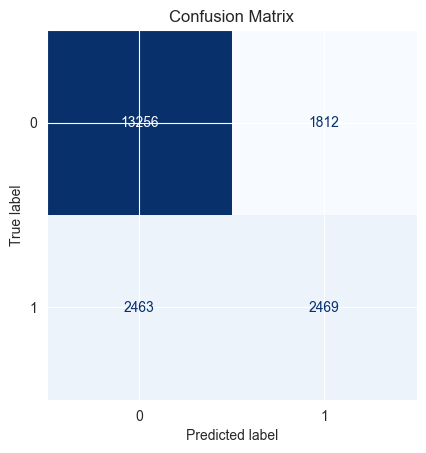

Loss: 0.46533915400505066
Classification accuracy: 85.94%


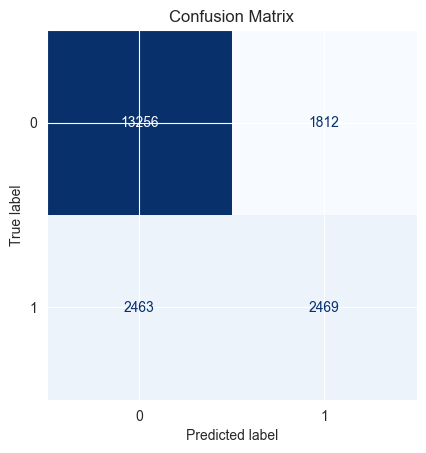

Loss: 0.49612531065940857
Classification accuracy: 81.25%


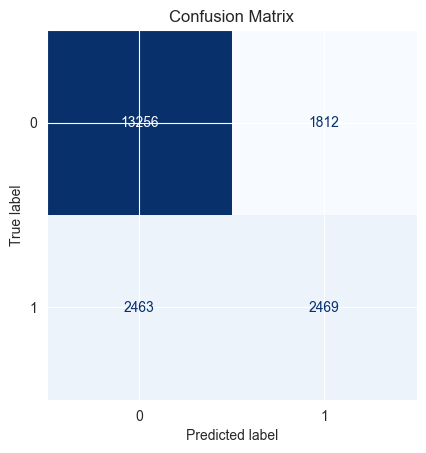

Loss: 0.5492175221443176
Classification accuracy: 71.88%


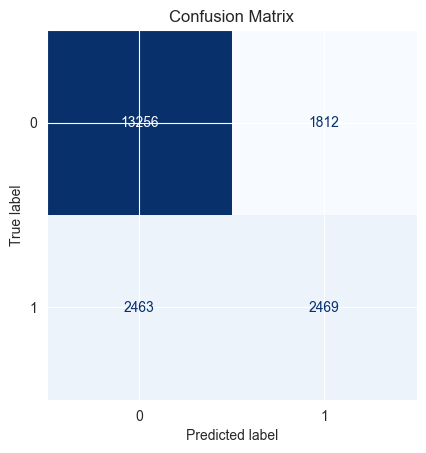

Loss: 0.5188714265823364
Classification accuracy: 78.12%


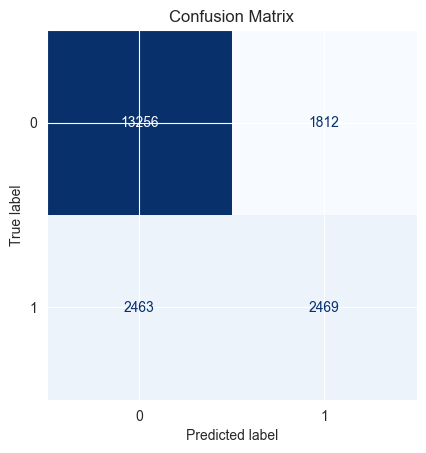

Loss: 0.46829861402511597
Classification accuracy: 84.38%


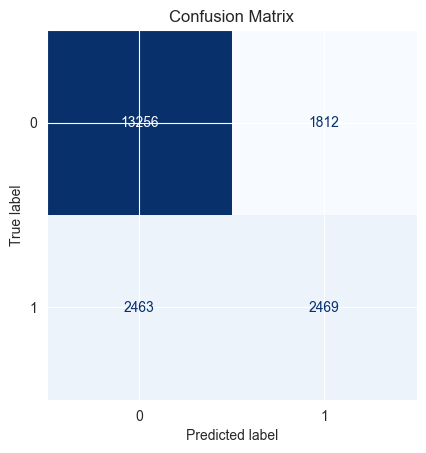

Loss: 0.5546029806137085
Classification accuracy: 75.00%


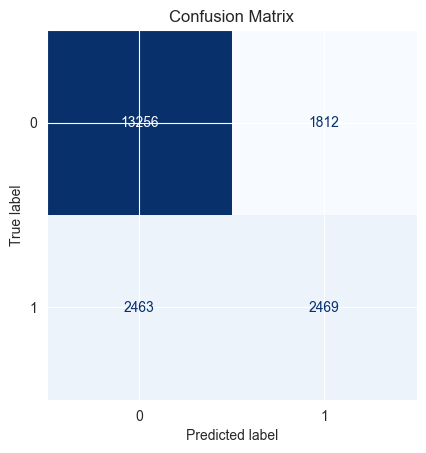

Loss: 0.5217444896697998
Classification accuracy: 79.69%


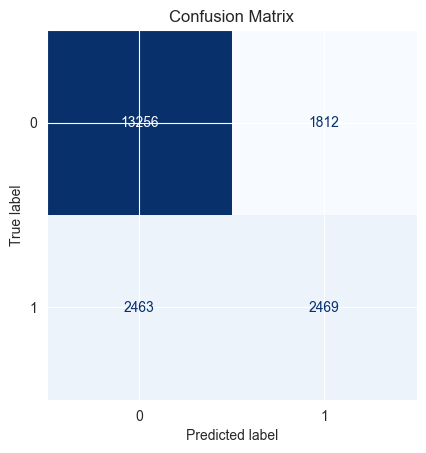

Loss: 0.4622657299041748
Classification accuracy: 84.38%


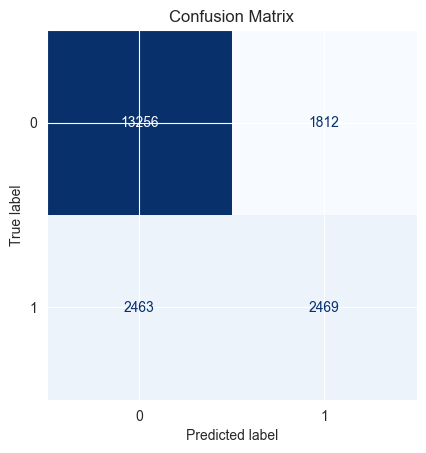

Loss: 0.5002832412719727
Classification accuracy: 81.25%


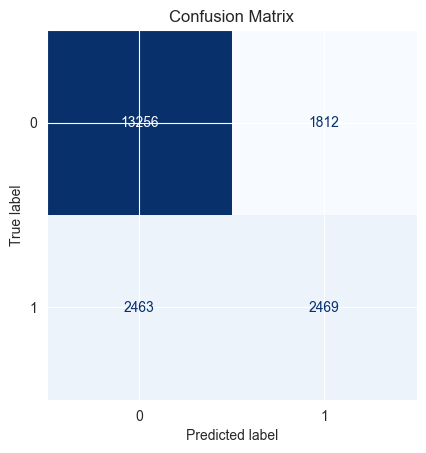

Loss: 0.4942598342895508
Classification accuracy: 82.81%


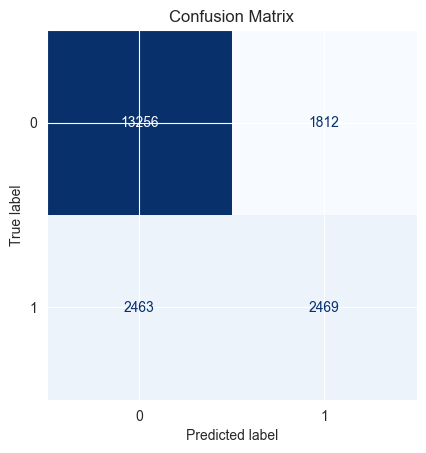

Loss: 0.6120021343231201
Classification accuracy: 68.75%


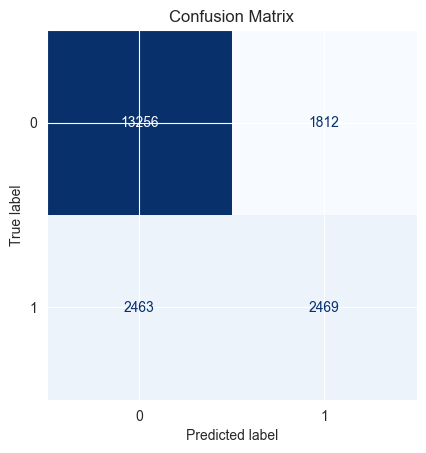

Loss: 0.41472187638282776
Classification accuracy: 89.06%


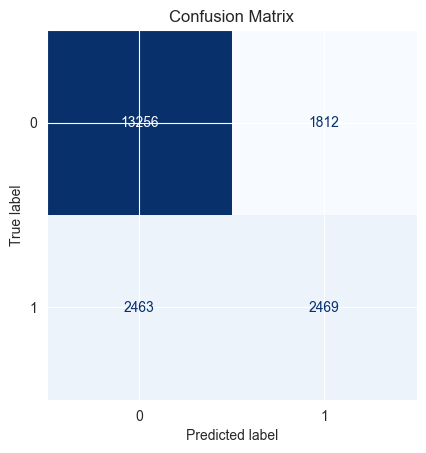

Loss: 0.5713459849357605
Classification accuracy: 71.88%


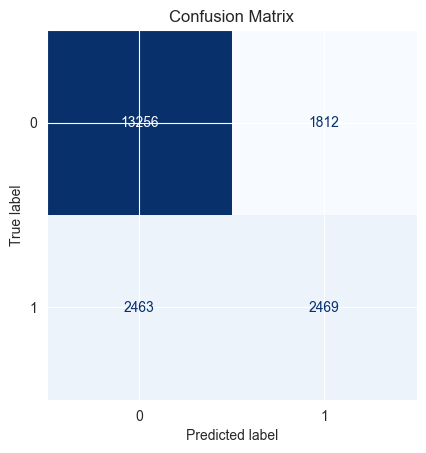

Loss: 0.46335071325302124
Classification accuracy: 84.38%


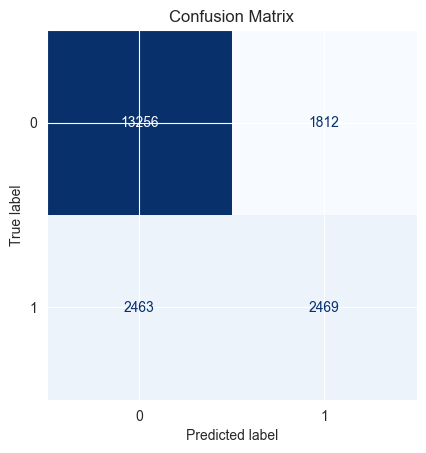

Loss: 0.49009695649147034
Classification accuracy: 81.25%


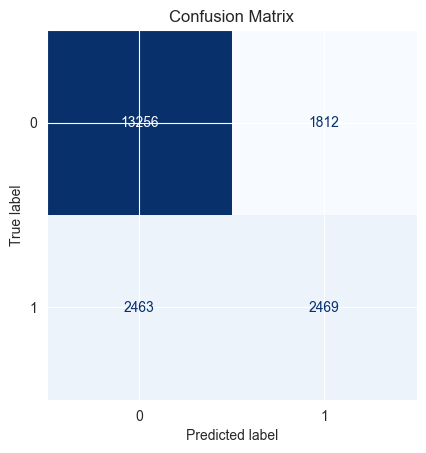

Loss: 0.5165818333625793
Classification accuracy: 79.69%


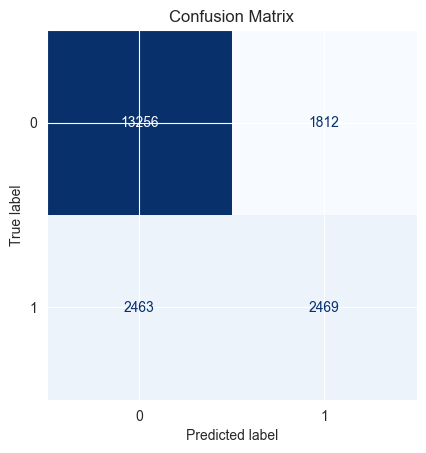

Loss: 0.501294732093811
Classification accuracy: 79.69%


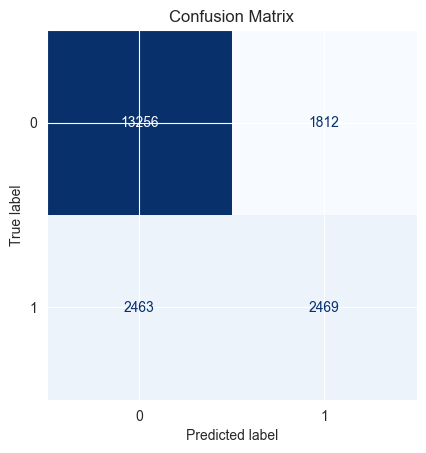

Loss: 0.4873763918876648
Classification accuracy: 82.81%


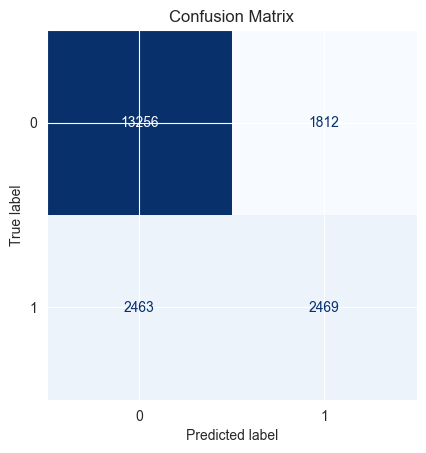

Loss: 0.41563478112220764
Classification accuracy: 87.50%


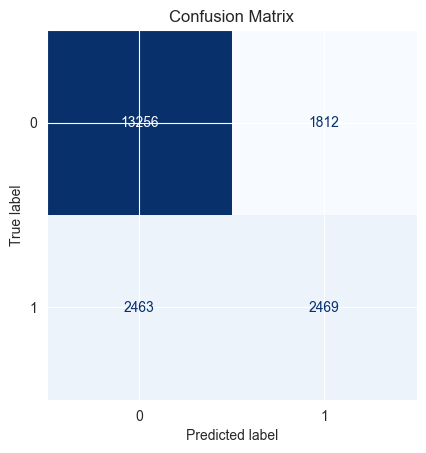

Loss: 0.4661477208137512
Classification accuracy: 84.38%


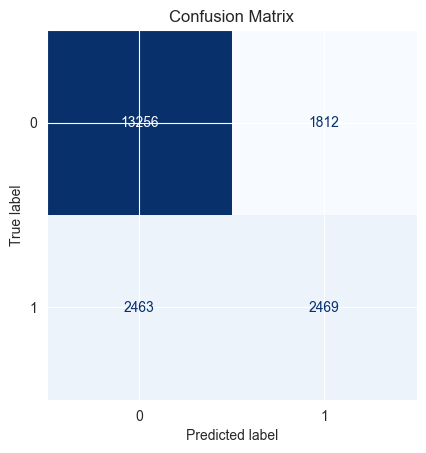

Loss: 0.49815478920936584
Classification accuracy: 81.25%


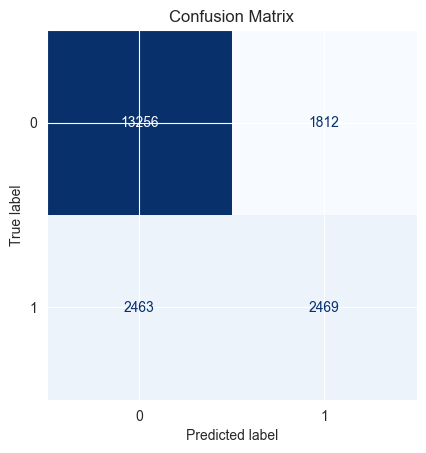

Loss: 0.44434744119644165
Classification accuracy: 87.50%


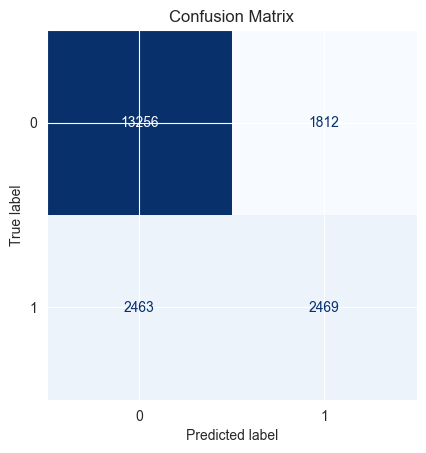

Loss: 0.5144340991973877
Classification accuracy: 79.69%


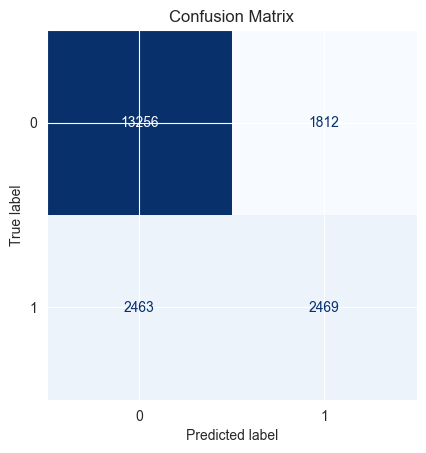

Loss: 0.5003098249435425
Classification accuracy: 81.25%


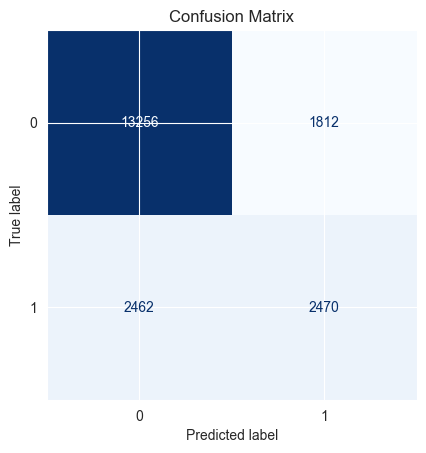

Loss: 0.5323824286460876
Classification accuracy: 76.56%


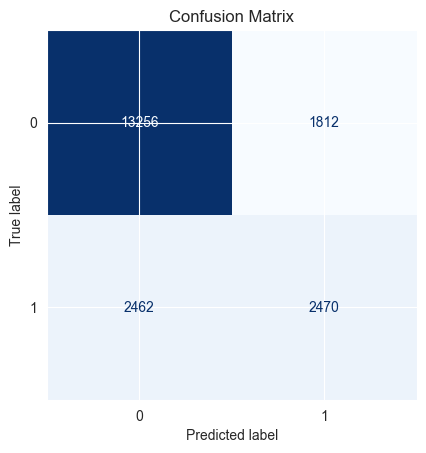

Loss: 0.543349027633667
Classification accuracy: 76.56%


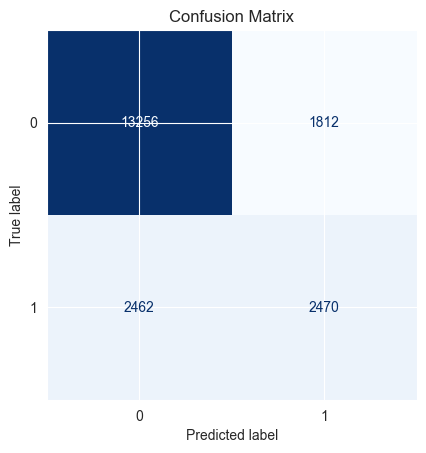

Loss: 0.4974716305732727
Classification accuracy: 79.69%


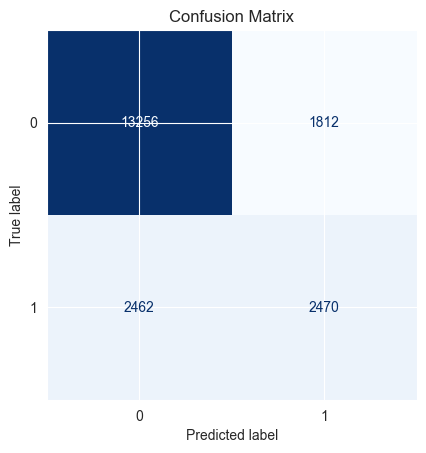

Loss: 0.649097740650177
Classification accuracy: 65.62%


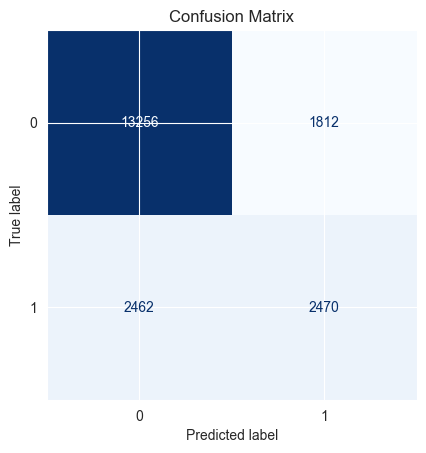

Loss: 0.44288358092308044
Classification accuracy: 87.50%


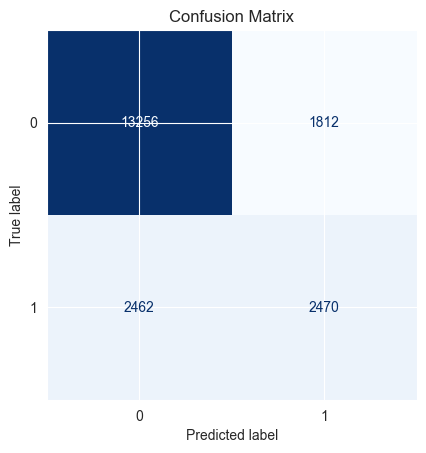

Loss: 0.483424574136734
Classification accuracy: 82.81%


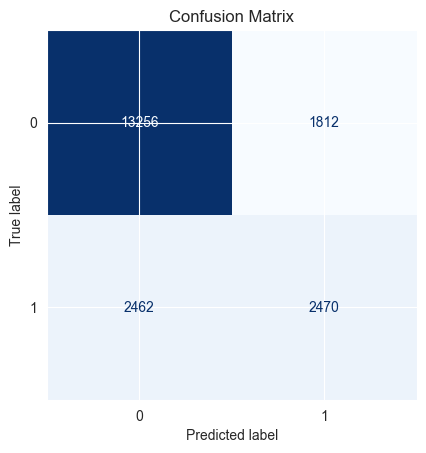

Loss: 0.5179275274276733
Classification accuracy: 79.69%


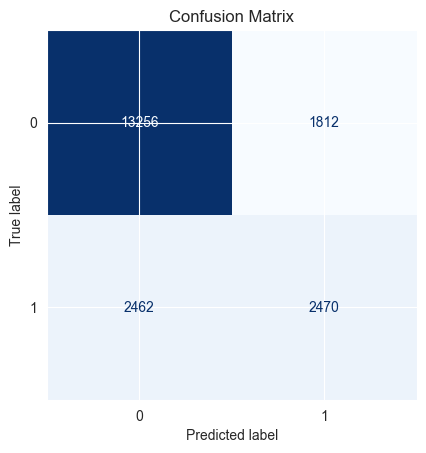

Loss: 0.49251261353492737
Classification accuracy: 82.81%


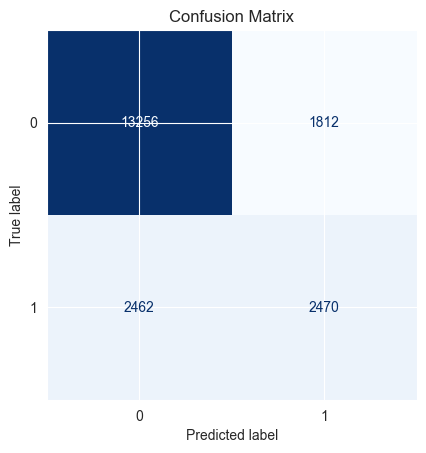

Loss: 0.44606563448905945
Classification accuracy: 87.50%


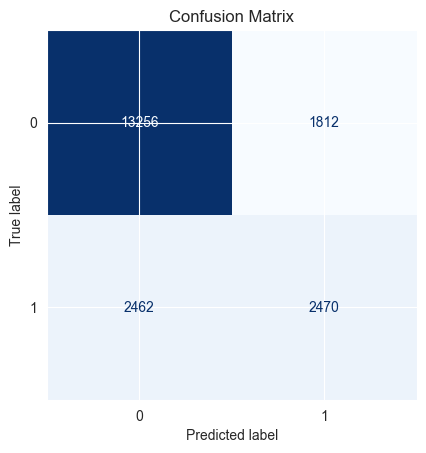

Loss: 0.5074808597564697
Classification accuracy: 81.25%


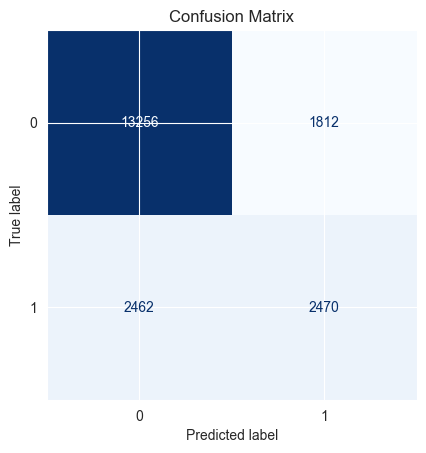

Loss: 0.48186904191970825
Classification accuracy: 82.81%


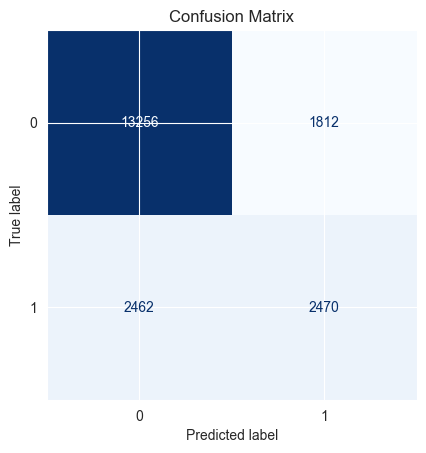

Loss: 0.4999893605709076
Classification accuracy: 81.25%


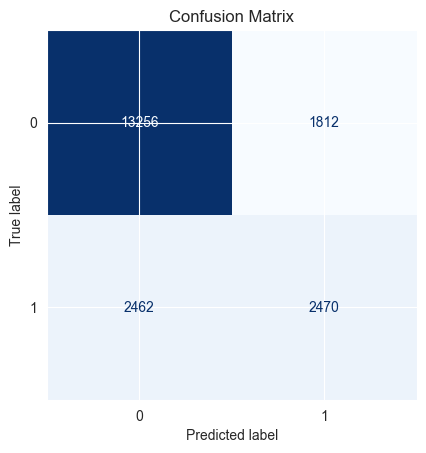

Loss: 0.5589520335197449
Classification accuracy: 70.31%


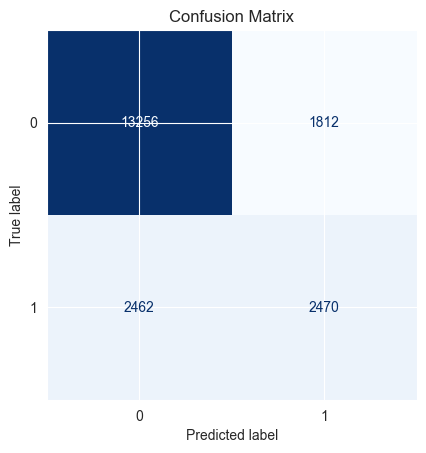

Loss: 0.523707389831543
Classification accuracy: 81.25%


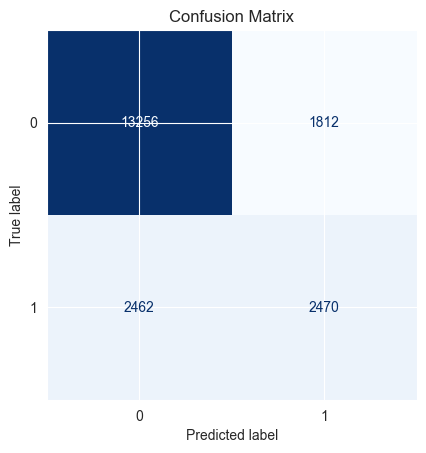

Loss: 0.44983363151550293
Classification accuracy: 85.94%


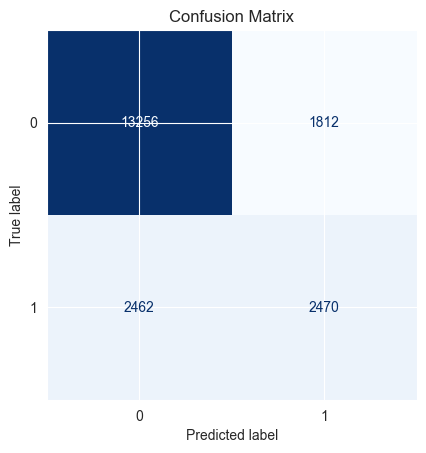

Loss: 0.5066388249397278
Classification accuracy: 81.25%


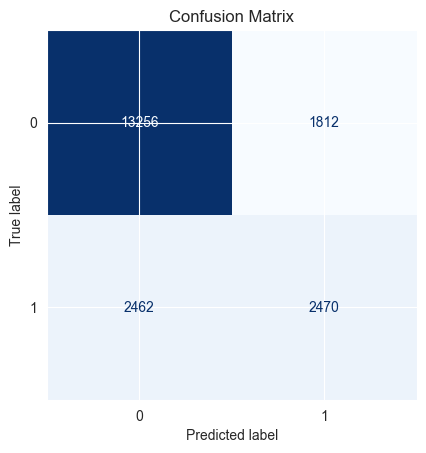

Loss: 0.5308923125267029
Classification accuracy: 76.56%


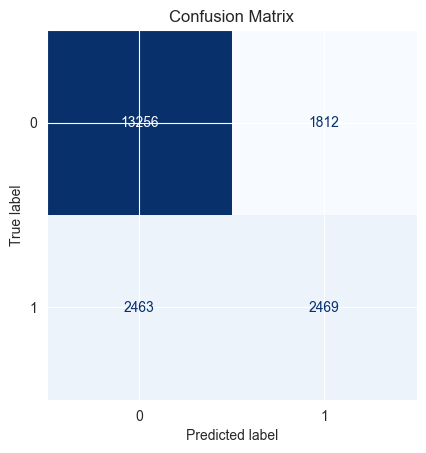

Loss: 0.5752320289611816
Classification accuracy: 71.88%


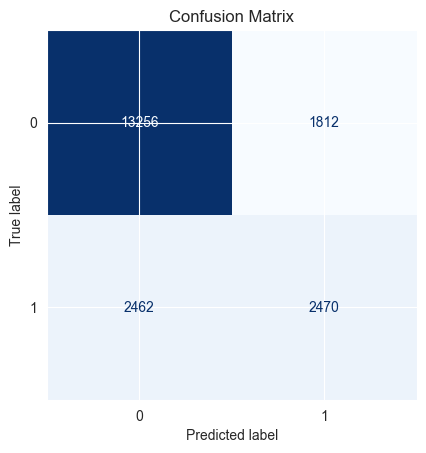

Loss: 0.5215376615524292
Classification accuracy: 76.56%


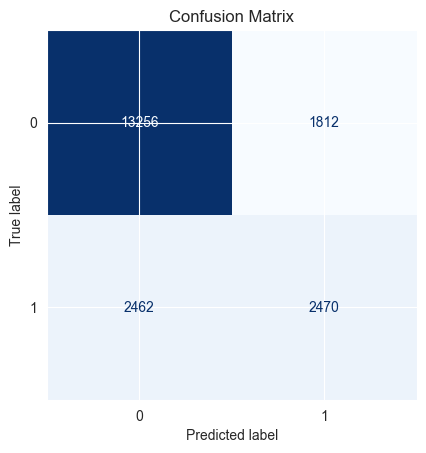

Loss: 0.462993323802948
Classification accuracy: 82.81%


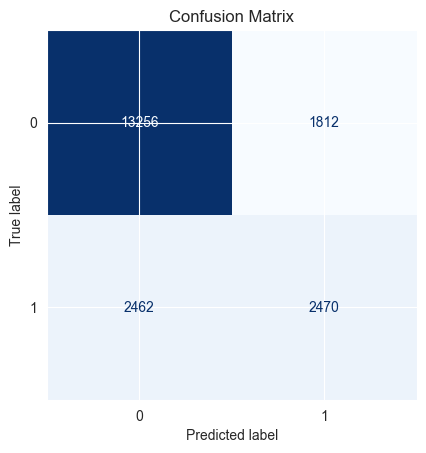

Loss: 0.4579818546772003
Classification accuracy: 85.94%


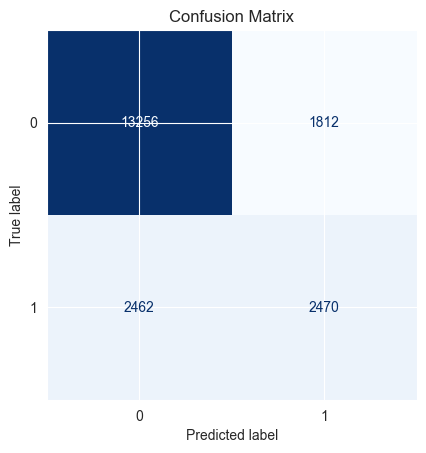

Loss: 0.5665524005889893
Classification accuracy: 76.56%


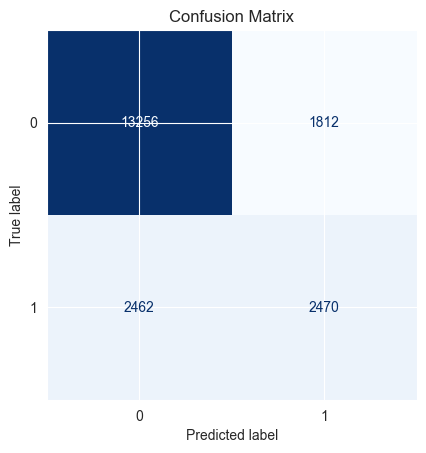

Loss: 0.5276689529418945
Classification accuracy: 78.12%


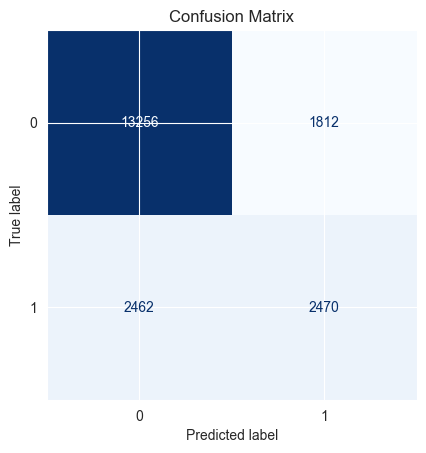

Loss: 0.5235888361930847
Classification accuracy: 76.56%


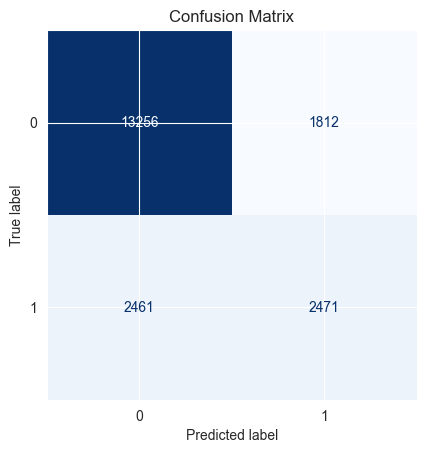

Loss: 0.49437111616134644
Classification accuracy: 81.25%


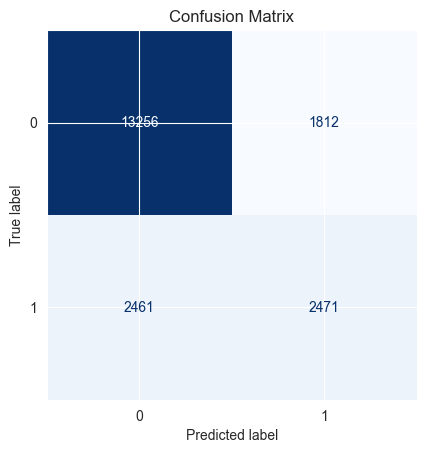

Loss: 0.43527036905288696
Classification accuracy: 87.50%


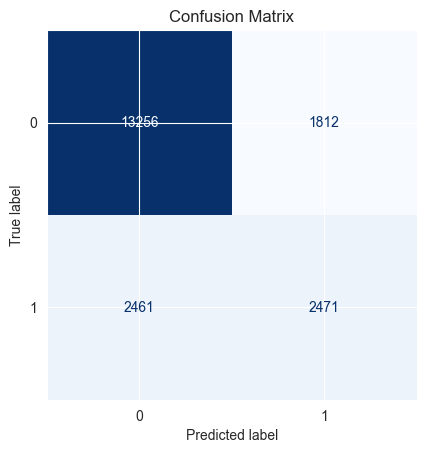

Loss: 0.5532929301261902
Classification accuracy: 78.12%


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

for epoch in range(5):
    print(f"Epoch: {epoch + 1}")
    # galaxy_classification_model.train()
    for  features, labels in training_dataset_loader:
        # 1. Forward Pass
        outputs = galaxy_classification_model(features) # Feed batches into NN -> Classifications
        loss = loss_function(outputs, labels) # Evaluate loss

        print(f"Loss: {loss.item()}")

        # 2. Backward Pass
        error_optimizer.zero_grad() #Calculate derivatives
        loss.backward() # Adjust weights
        error_optimizer.step()  # ??

        # 3. Display statistics
        galaxy_classification_model.eval() # Put model into evaluation mode.
        correct = 0
        total   = 0


        with torch.no_grad():                    # no gradients needed for evaluation
            # for features, labels in testing_dataset_loader:
                # features, labels = features.to(device), labels.to(device)

            _, predicted = torch.max(outputs, 1)  # index of largest logit = predicted class

            total   += labels.size(0)         # number of samples in this batch
            correct += (predicted == labels).sum().item()

        accuracy = correct / total
        print(f"Classification accuracy: {accuracy:.2%}")

        all_preds, all_labels = [], []
        with torch.no_grad():
            for features, labels in testing_dataset_loader:
                outputs = galaxy_classification_model(features.to(device))
                _, predicted = torch.max(outputs, 1)
                all_preds.append(predicted.cpu())
                all_labels.append(labels)

        all_preds  = torch.cat(all_preds).numpy()
        all_labels = torch.cat(all_labels).numpy()

        cm = confusion_matrix(all_labels, all_preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues', colorbar=False)
        plt.title("Confusion Matrix")
        plt.show()

    print(f"Epoch: {epoch + 1} completed.")

